# 需要ショックと供給ショックについて：AD-ASモデルの状態空間分析

In [1]:
import arviz as az
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as at
import py4macro
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy.linalg import multi_dot
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate,
    unconstrain_stationary_univariate)
from statsmodels.tsa.statespace import initialization
from statsmodels.tsa.statespace import tools
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import breakvar_heteroskedasticity_test
from statsmodels.stats.diagnostic import acorr_ljungbox

## Data

In [2]:
var_list = ['gdp','deflator','price']
data = py4macro.data('jpn-q').loc[:,var_list]
data.index.freq = 'Q'

for c in var_list:
    data[c+'_log'] = data[c].apply(np.log)

data['y'] = data['gdp_log'] - py4macro.trend(data['gdp_log'])
data['p'] = data['deflator_log'] - py4macro.trend(data['deflator_log'])

In [3]:
result = {}

for v in ['y','p']:
    result[v+'_std'] = data[v].std()

for v in ['y','p']:
    result[v+'_autocorr'] = data[v].autocorr()

result['yp_corr'] = data[['y', 'p']].corr().iloc[0,1]

yp_corr_12 = []

for n in range(0,12+1):
    data['p_shift'] = data['p'].shift(-n)
    corr = data[['y', 'p_shift']].corr().iloc[0,1]
    yp_corr_12.append(corr)
    del data['p_shift']

df = ( pd.DataFrame(result, index=['Data']),
       pd.DataFrame({'yp_corr_12':yp_corr_12})
     )

In [4]:
df[0]

,y_std,p_std,y_autocorr,p_autocorr,yp_corr
Data,0.014765,0.006958,0.680889,0.82934,-0.233978


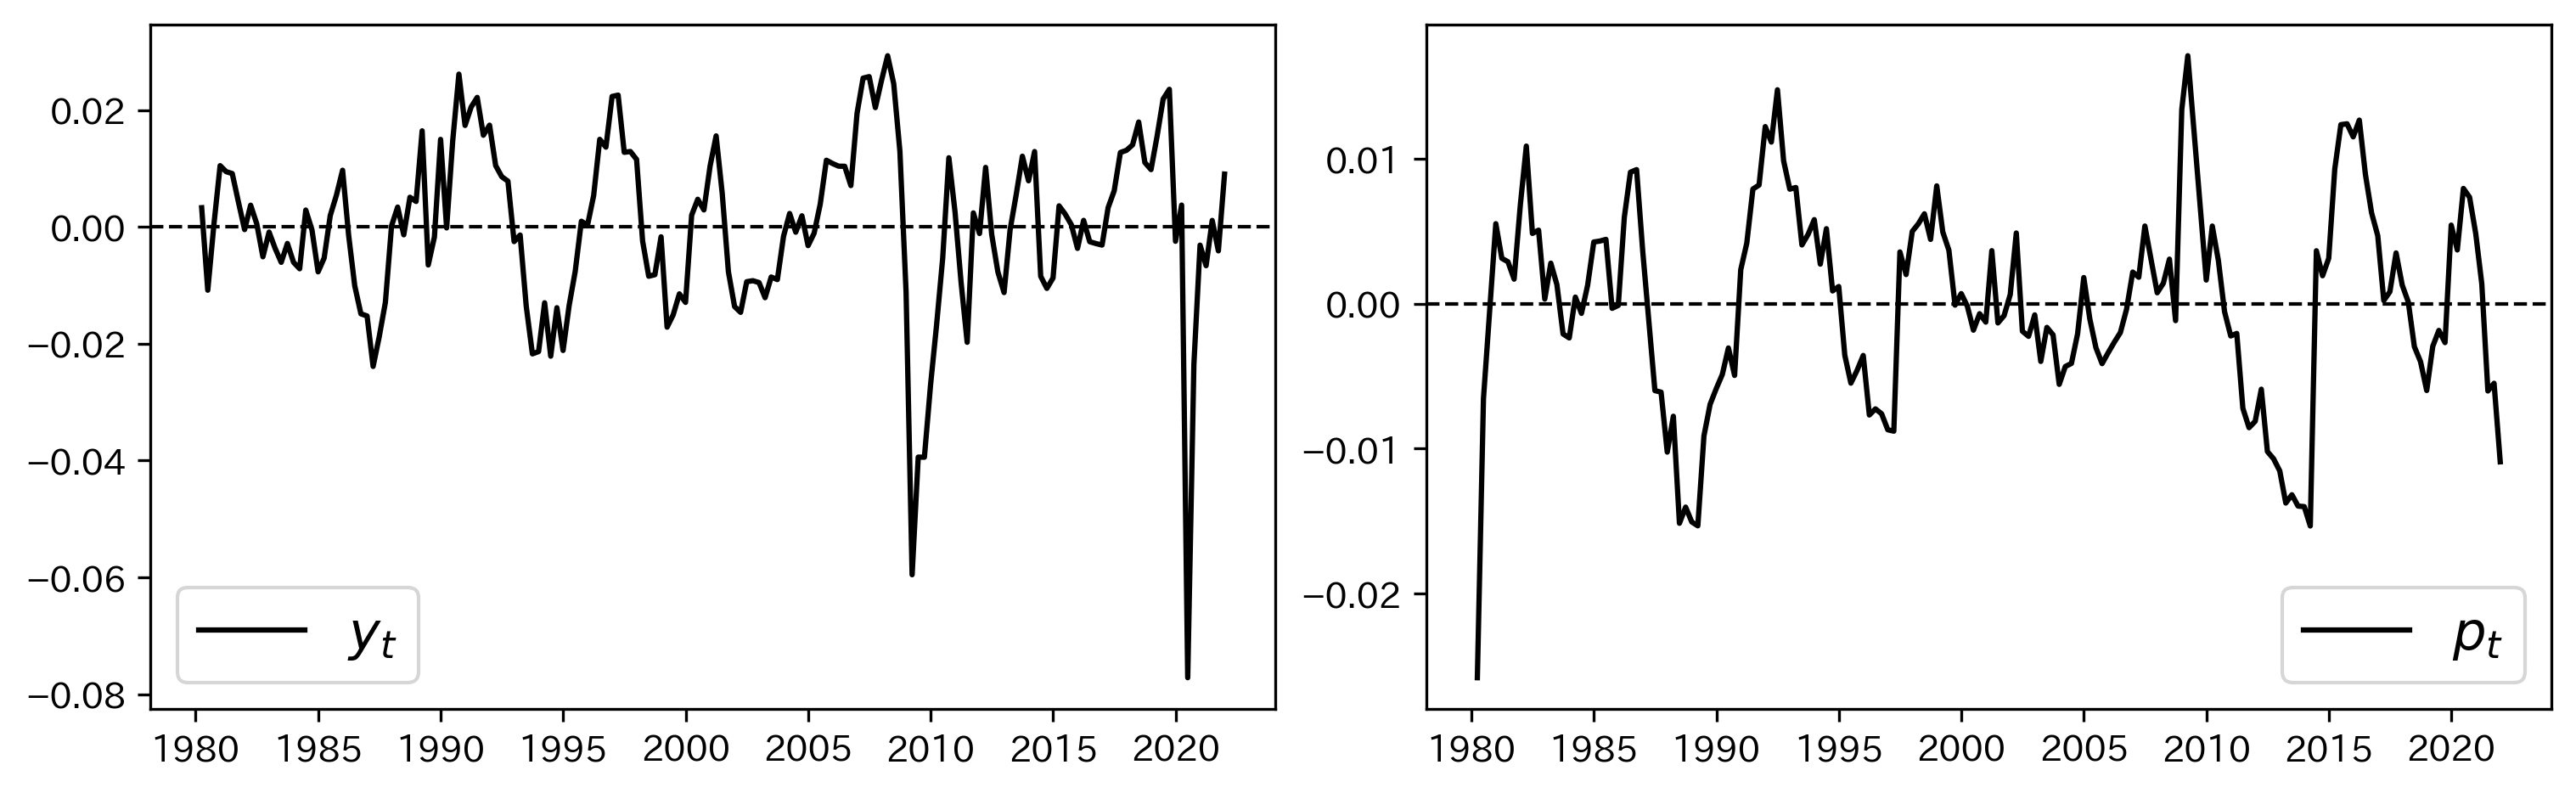

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,3), dpi=300, constrained_layout=True)
ax[0].plot('y', data=data, color='k')
ax[1].plot('p', data=data, color='k')
ax[0].axhline(0, color='k', linestyle='--', lw=1)
ax[1].axhline(0, color='k', linestyle='--', lw=1)
ax[0].legend([r'$y_t$'], fontsize=15, loc='lower left')
ax[1].legend([r'$p_t$'], fontsize=15, loc='lower right')
pass

## MLE

### `Class`

In [6]:
class ADAS4rho(sm.tsa.statespace.MLEModel):
    
    param_names = ['c', 'a', 'rho_u', 'rho_v', 'std_eu', 'std_ev']
    start_params = [0.5,0.5,0.5,0.5,0.1,0.1]

    def __init__(self, endog):

        # Extract data for 'obs_intercept'
        Z = sm.tsa.lagmat(endog, maxlag=1, trim='both', original='in')
        endog = endog.iloc[1:,:]
        self.P_lagged = Z[:,3]

        # Initialize the state space model
        super(ADAS4rho, self).__init__(endog, k_states=2, k_posdef=2,
                         initialization='stationary'
                                      )
        self['design'] = [[1, 1],
                          [1, 1]]
        self['transition'] = [[1, 0],
                              [0, 1]]
        self['selection'] = [[1,0],
                             [0,1]]
                
    def transform_params(self, params):
        params = params.copy()
        params[:2] = params[:2]**2
        params[2:3] = tools.constrain_stationary_univariate(params[2:3])
        params[3:4] = tools.constrain_stationary_univariate(params[3:4])
        params[-2:] = params[-2:]**2
        return params
    
    def untransform_params(self, params):
        params = params.copy()
        params[:2] = params[:2]**0.5
        params[2:3] = tools.unconstrain_stationary_univariate(params[2:3])
        params[3:4] = tools.unconstrain_stationary_univariate(params[3:4])
        params[-2:] = params[-2:]**0.5
        return params

    # Describe how parameters enter the model
    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)

        # Here is where we're putting the lagged endog
        self['obs_intercept'] = np.stack( [-params[0]*self.P_lagged,
                                           self.P_lagged]
                                        )/(1+params[0]*params[1])
        self['design', 0, 0] = 1/(1+params[0]*params[1]) # h
        self['design', 0, 1] = -params[0]/(1+params[0]*params[1]) # ch
        self['design', 1, 0] = params[1]/(1+params[0]*params[1]) # ah
        self['design', 1, 1] = 1/(1+params[0]*params[1]) # h
        self['transition', 0, 0] = params[2]
        self['transition', 1, 1] = params[3]
        self['state_cov', 0, 0] = params[4]**2  # var_u
        self['state_cov', 1, 1] = params[5]**2  # var_v

### MLE

In [7]:
mod_mle = ADAS4rho( data[['y','p']] )

res_mle = mod_mle.fit(maxiter=1000, disp=False)
res_mle = mod_mle.fit(res_mle.params, method='nm', maxiter=1000)
hhat = 1/(1+res_mle.params[0]*res_mle.params[1])
print(f'hhat: {hhat}')

Optimization terminated successfully.
         Current function value: -7.321619
         Iterations: 80
         Function evaluations: 145
hhat: 0.7413902489375367


In [8]:
print(res_mle.summary())

                           Statespace Model Results                           
Dep. Variable:             ['y', 'p']   No. Observations:                  167
Model:                       ADAS4rho   Log Likelihood                1222.710
Date:                Sun, 23 Apr 2023   AIC                          -2433.421
Time:                        14:53:57   BIC                          -2414.713
Sample:                    06-30-1980   HQIC                         -2425.827
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c              2.0691      0.408      5.077      0.000       1.270       2.868
a              0.1686      0.054      3.136      0.002       0.063       0.274
rho_u          0.7667      0.051     15.134      0.0

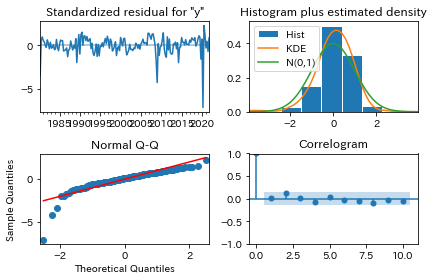

In [9]:
res_mle.plot_diagnostics(0).tight_layout()

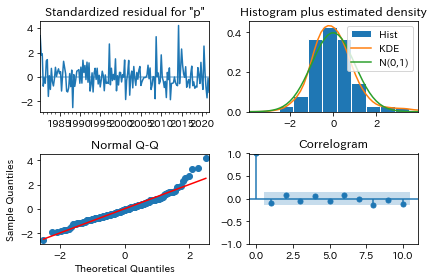

In [10]:
res_mle.plot_diagnostics(1).tight_layout()

## Bayesian Estimation

### Helper Functions

In [11]:
# Helper functions copied. Do not know how they work
class Loglike(at.Op):

    itypes = [at.dvector] # expects a vector of parameter values when called
    otypes = [at.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(at.Op):
    itypes = [at.dvector]
    otypes = [at.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)       

### `Priors`

In [12]:
mass = 0.95
lower = 0.1*res_mle.params['std_eu']
upper = 10.0*res_mle.params['std_eu']
constrained_priors = pm.find_constrained_prior(
    pm.InverseGamma, lower=lower, upper=upper, mass=mass,
    init_guess=dict(alpha=0.01, beta=0.001)
)
alpha_eu = constrained_priors['alpha']
beta_eu = constrained_priors['beta']
print(alpha_eu, beta_eu)

1.0699119937039103 0.006961630955364359


/Users/user/opt/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/user/opt/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


In [13]:
mass = 0.95
lower = 0.1*res_mle.params['std_ev']
upper = 10.*res_mle.params['std_ev']
constrained_priors = pm.find_constrained_prior(
    pm.InverseGamma, lower=lower, upper=upper, mass=mass,
    init_guess=dict(alpha=0.01, beta=0.0001)
)
alpha_ev = constrained_priors['alpha']
beta_ev = constrained_priors['beta']
print(alpha_ev, beta_ev)

1.11683005857035 0.0018042900822553192


/Users/user/opt/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/user/opt/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


### `pymc`

#### 計算

In [14]:
mod_mle.start_params = res_mle.params.tolist()
loglike = Loglike(mod_mle)

# Set sample size
ndraws = 3000  # number of draws from the distribution
nburn = 500   # number of "burn-in points" (which will be discarded)

# Sample from posterior
with pm.Model():
    # Priors
    c = pm.TruncatedNormal('c', mu=res_mle.params['c'], sigma=0.1, lower=0.001)
    a = pm.TruncatedNormal('a', mu=res_mle.params['a'], sigma=0.01, lower=0.0001)
    rho_u = pm.Uniform('rho_u', -0.99, 0.99)
    rho_v = pm.Uniform('rho_v', -0.99, 0.99)
    std_eu = pm.InverseGamma('std_eu', alpha_eu, beta_eu)
    std_ev = pm.InverseGamma('std_ev', alpha_ev, beta_ev)
    
    # var names
    var_names = [c, a, rho_u, rho_v, std_eu, std_ev]

    # convert variables to tensor vectors
    theta = at.as_tensor_variable(var_names)

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.Potential('likelihood', loglike(theta))

    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=1, chains=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (5 chains in 1 job)
NUTS: [c, a, rho_u, rho_v, std_eu, std_ev]


Sampling 5 chains for 500 tune and 3_000 draw iterations (2_500 + 15_000 draws total) took 748 seconds.


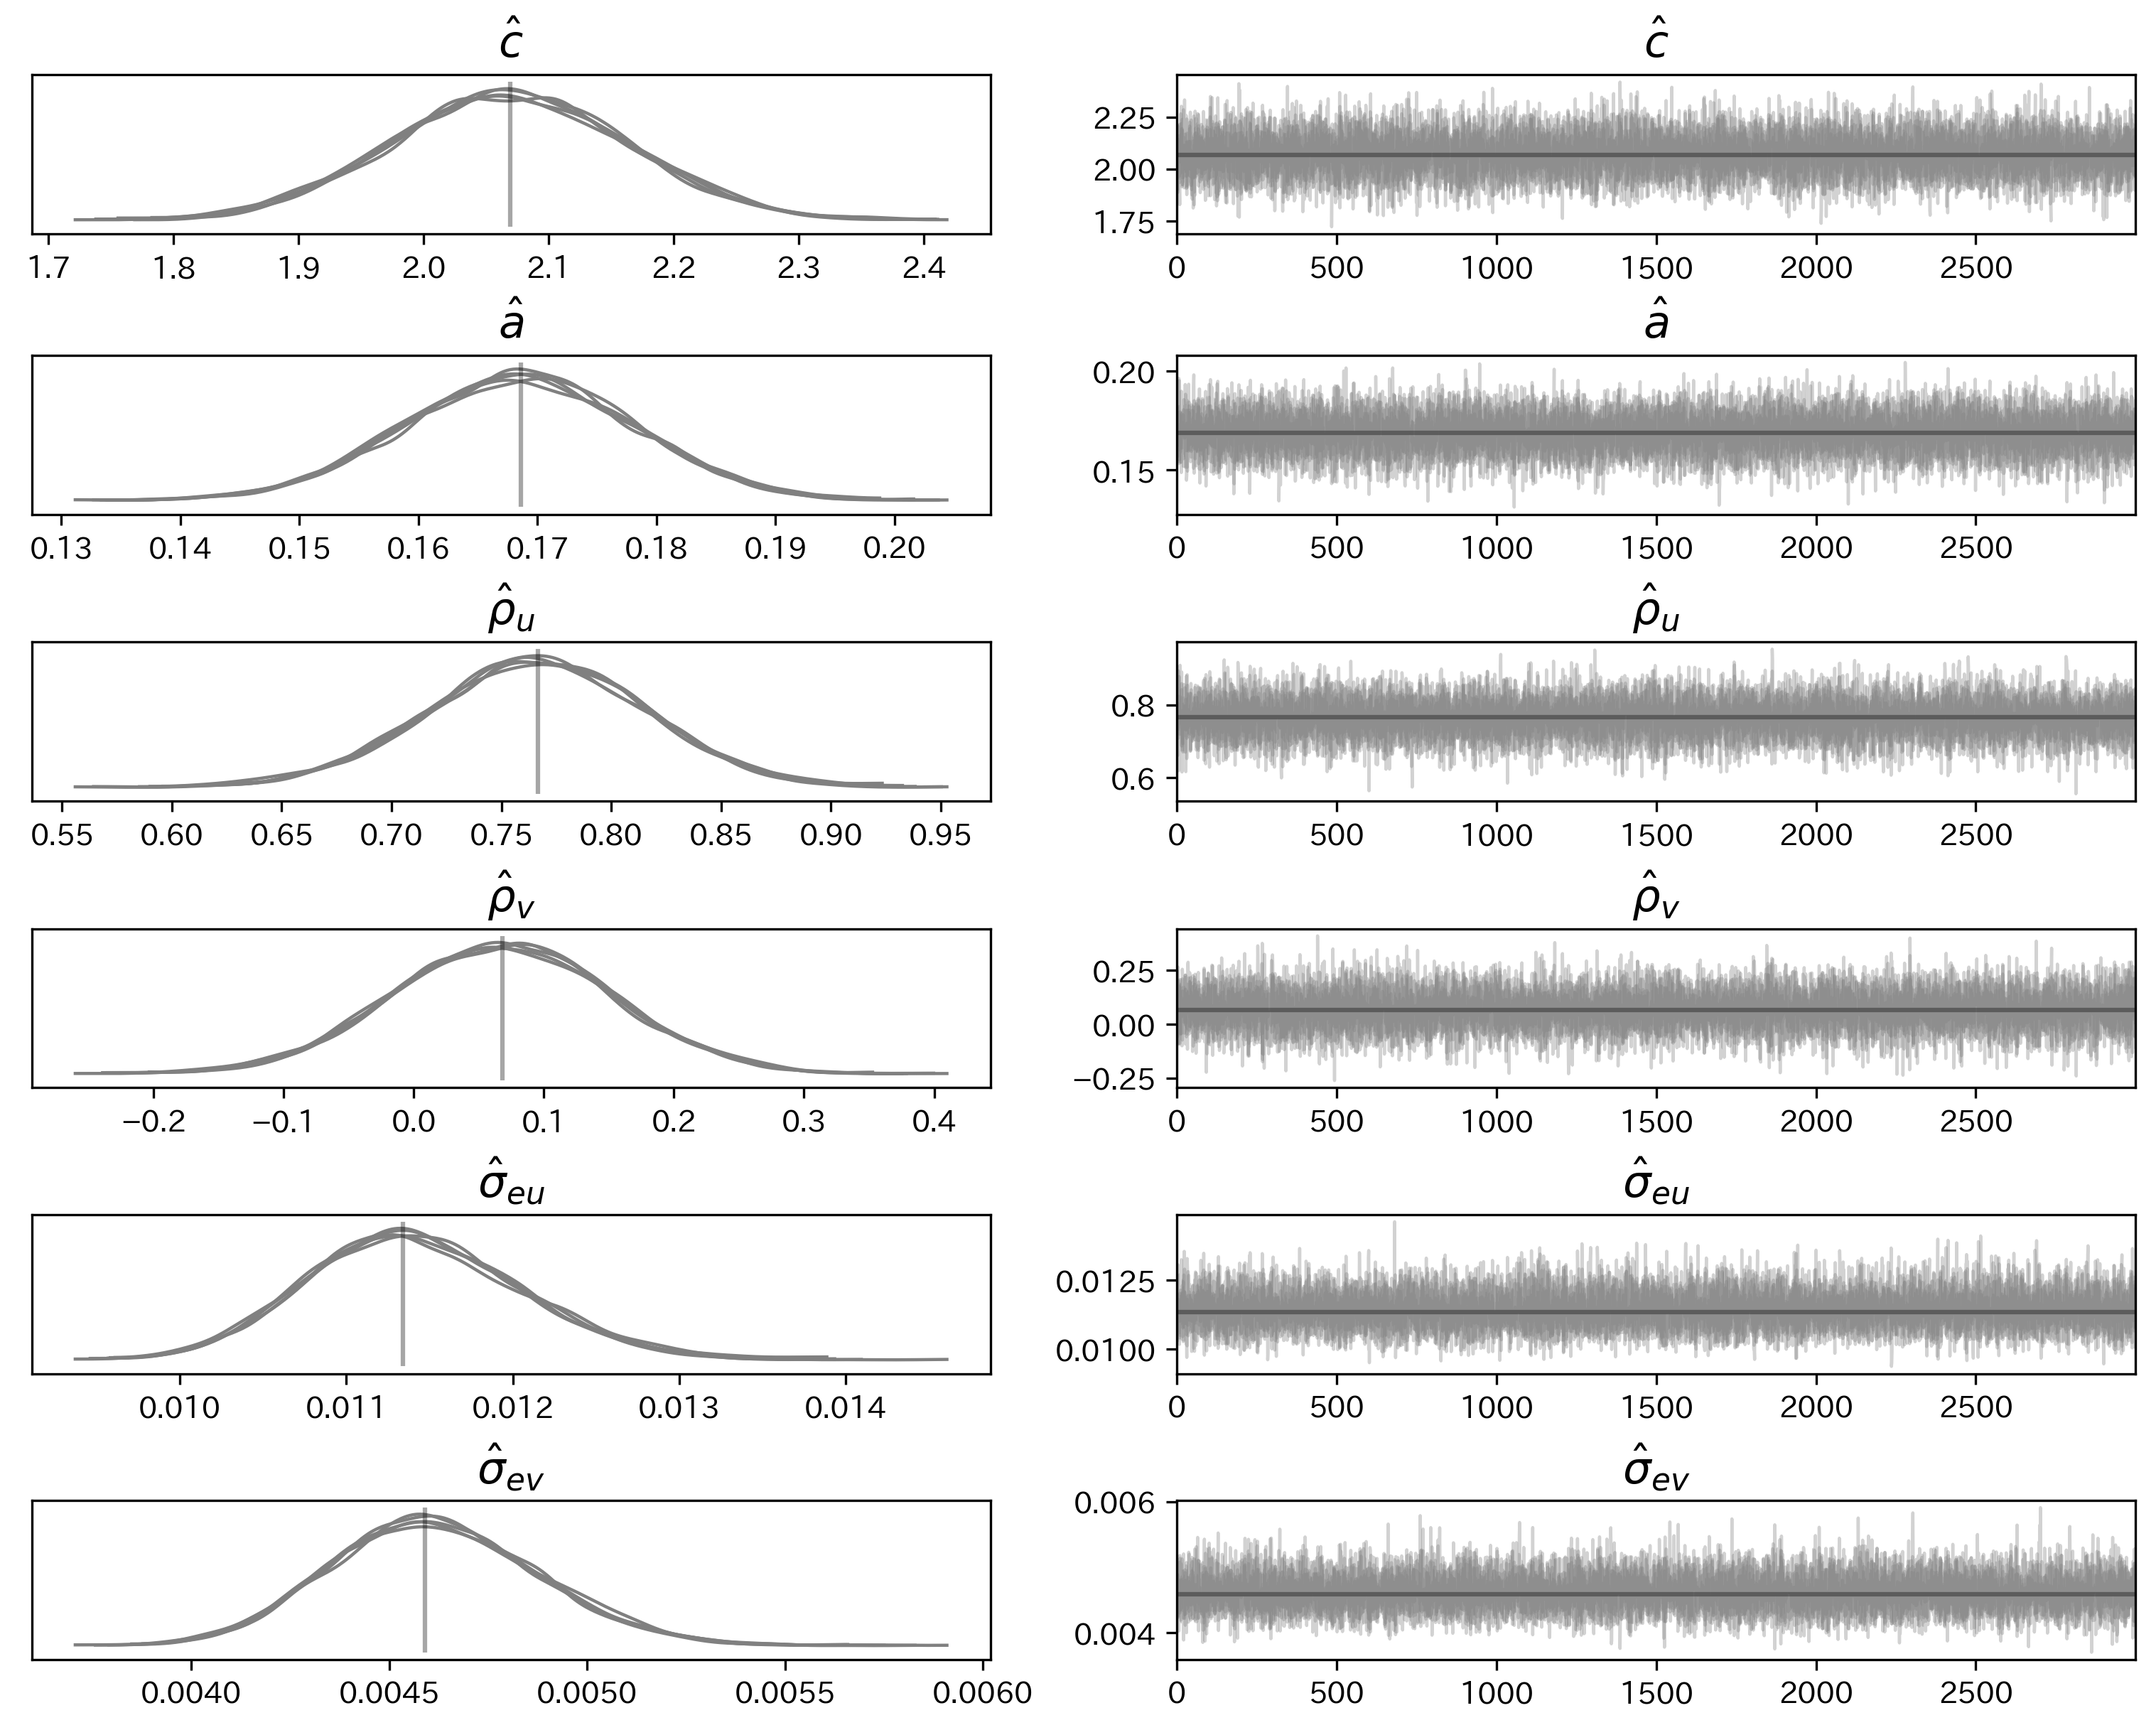

In [89]:
ax = az.plot_trace(
    data=trace,
    lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
    chain_prop={"color": ['gray']},
    figsize=(10, 8),
    backend_kwargs={"constrained_layout":True, "dpi":300})

for i, v in enumerate([r'$\hat{c}$',r'$\hat{a}$',
                       r'$\hat{\rho}_u$',r'$\hat{\rho}_v$',
                       r'$\hat{\sigma}_{eu}$',r'$\hat{\sigma}_{ev}$']):
    ax[i,0].set_title(v, fontsize=15)
    ax[i,1].set_title(v, fontsize=15)

In [16]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,2.069,0.094,1.893,2.246,0.001,0.001,15038.0,11677.0,1.0
a,0.168,0.010,0.150,0.186,0.000,0.000,14821.0,11529.0,1.0
rho_u,0.766,0.050,0.673,0.861,0.000,0.000,15369.0,9205.0,1.0
rho_v,0.068,0.085,-0.083,0.236,0.001,0.001,15433.0,10691.0,1.0
std_eu,0.011,0.001,0.010,0.013,0.000,0.000,15276.0,11556.0,1.0
std_ev,0.005,0.000,0.004,0.005,0.000,0.000,15743.0,12920.0,1.0


#### `c`

In [17]:
def three_moments(x):
    
    def find_mode(x):
        ss = az.kde(x)
        max_ = ss[1].max()
        idx_mode = np.where(ss[1]==max_)[0]
        return ss[0][idx_mode][0]
    
    mean_ = x.mean()
    median_ = x.median()
    mode_ = find_mode(x)
    
    return mean_, median_, mode_

(2.068753810481372, 2.0679621760791607, 2.0610619606281224)


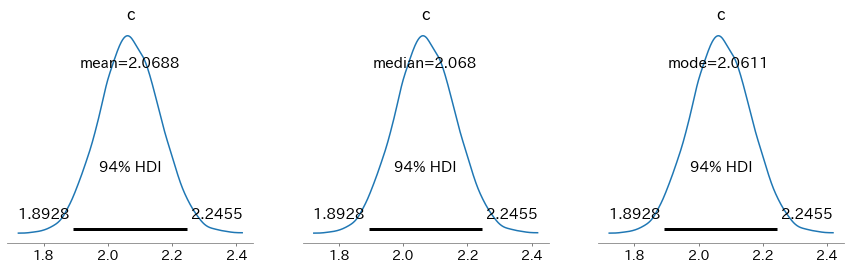

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(trace, var_names='c', ax=ax[0],point_estimate='mean',round_to=5)
az.plot_posterior(trace, var_names='c', ax=ax[1],point_estimate='median',round_to=5)
az.plot_posterior(trace, var_names='c', ax=ax[2],point_estimate='mode',round_to=5)
print(three_moments(trace.to_dataframe().iloc[:,2]))
pass

#### `a`

(0.168413778697791, 0.16844232610663729, 0.16842986791915732)


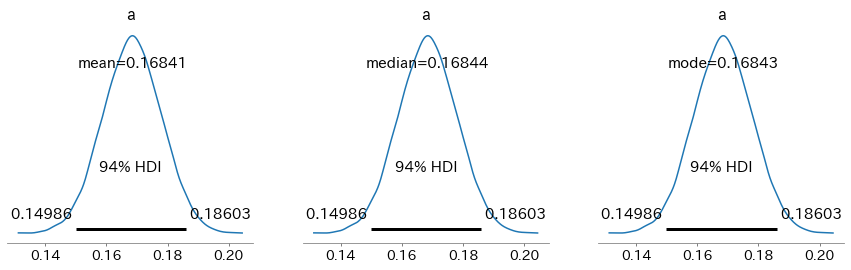

In [19]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(trace, var_names='a', ax=ax[0],point_estimate='mean',round_to=5)
az.plot_posterior(trace, var_names='a', ax=ax[1],point_estimate='median',round_to=5)
az.plot_posterior(trace, var_names='a', ax=ax[2],point_estimate='mode',round_to=5)
print(three_moments(trace.to_dataframe().iloc[:,3]))
pass

#### `rho_u`

(0.7660732492106702, 0.7661660039793945, 0.7602422440073138)


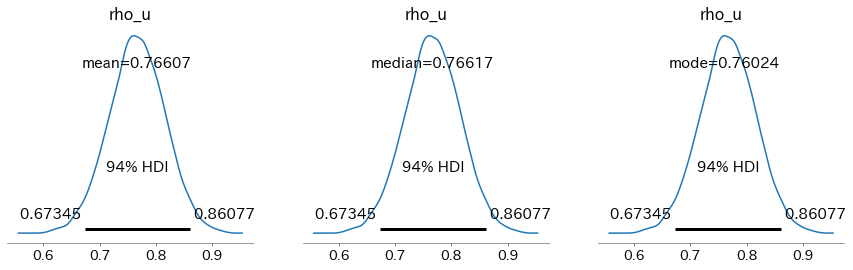

In [20]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(trace, var_names='rho_u', ax=ax[0],point_estimate='mean',round_to=5)
az.plot_posterior(trace, var_names='rho_u', ax=ax[1],point_estimate='median',round_to=5)
az.plot_posterior(trace, var_names='rho_u', ax=ax[2],point_estimate='mode',round_to=5)
print(three_moments(trace.to_dataframe().iloc[:,4]))
pass

#### `rho_v`

(0.06808458311616244, 0.06832160069003201, 0.07281302269941822)


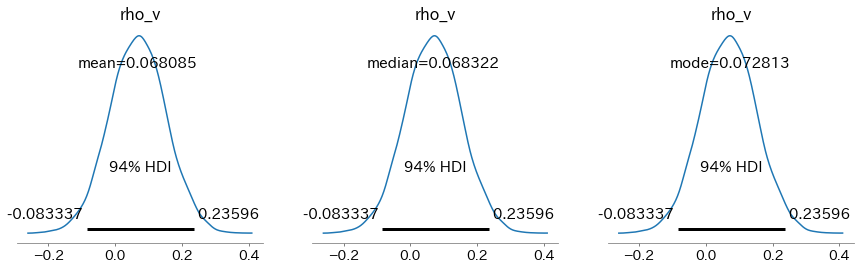

In [21]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(trace, var_names='rho_v', ax=ax[0],point_estimate='mean',round_to=5)
az.plot_posterior(trace, var_names='rho_v', ax=ax[1],point_estimate='median',round_to=5)
az.plot_posterior(trace, var_names='rho_v', ax=ax[2],point_estimate='mode',round_to=5)
print(three_moments(trace.to_dataframe().iloc[:,5]))
pass

#### `std_eu`

(0.01141564430455286, 0.011375299728708994, 0.01132879449611841)


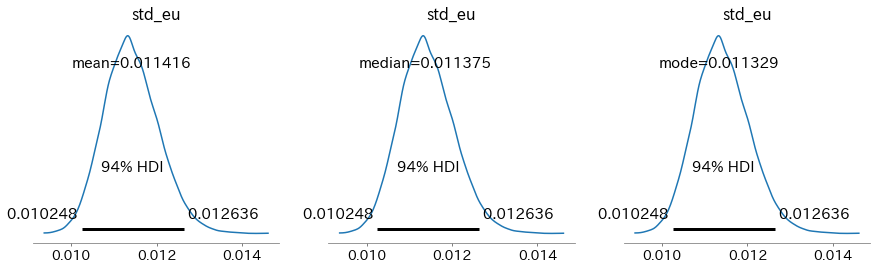

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(trace, var_names='std_eu', ax=ax[0],point_estimate='mean',round_to=5)
az.plot_posterior(trace, var_names='std_eu', ax=ax[1],point_estimate='median',round_to=5)
az.plot_posterior(trace, var_names='std_eu', ax=ax[2],point_estimate='mode',round_to=5)
print(three_moments(trace.to_dataframe().iloc[:,6]))
pass

#### `std_ev`

(0.004616259002802022, 0.004605217996895305, 0.0045859603029685505)


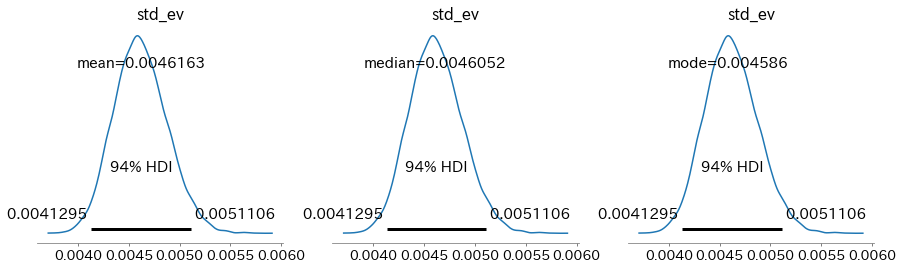

In [23]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(trace, var_names='std_ev', ax=ax[0],point_estimate='mean',round_to=5)
az.plot_posterior(trace, var_names='std_ev', ax=ax[1],point_estimate='median',round_to=5)
az.plot_posterior(trace, var_names='std_ev', ax=ax[2],point_estimate='mode',round_to=5)
print(three_moments(trace.to_dataframe().iloc[:,7]))
pass

#### `trace`の自己相関係数

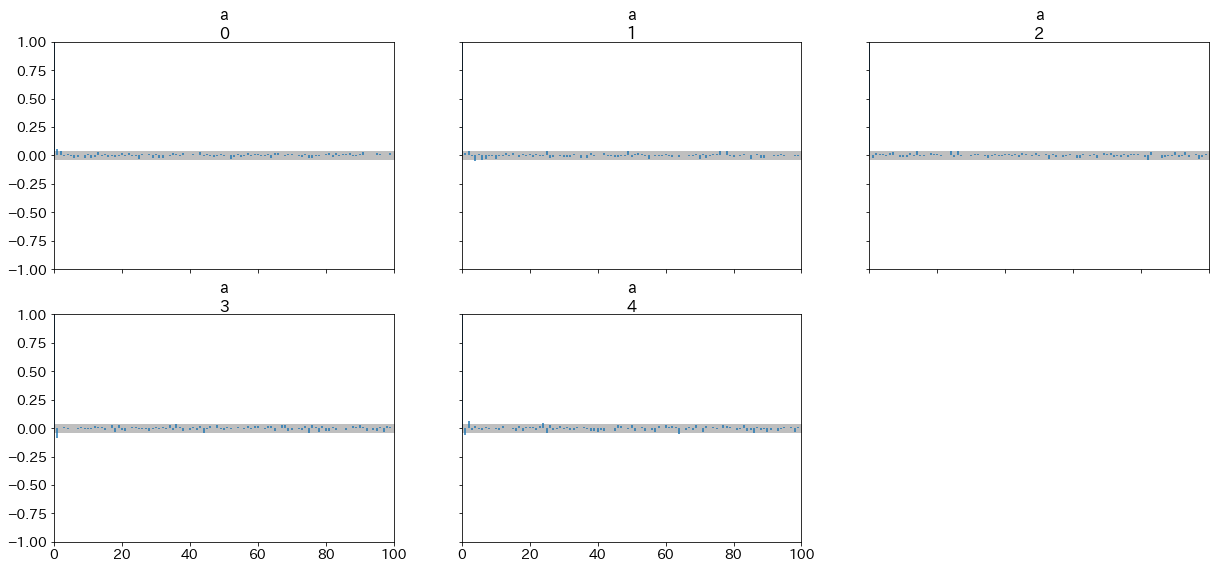

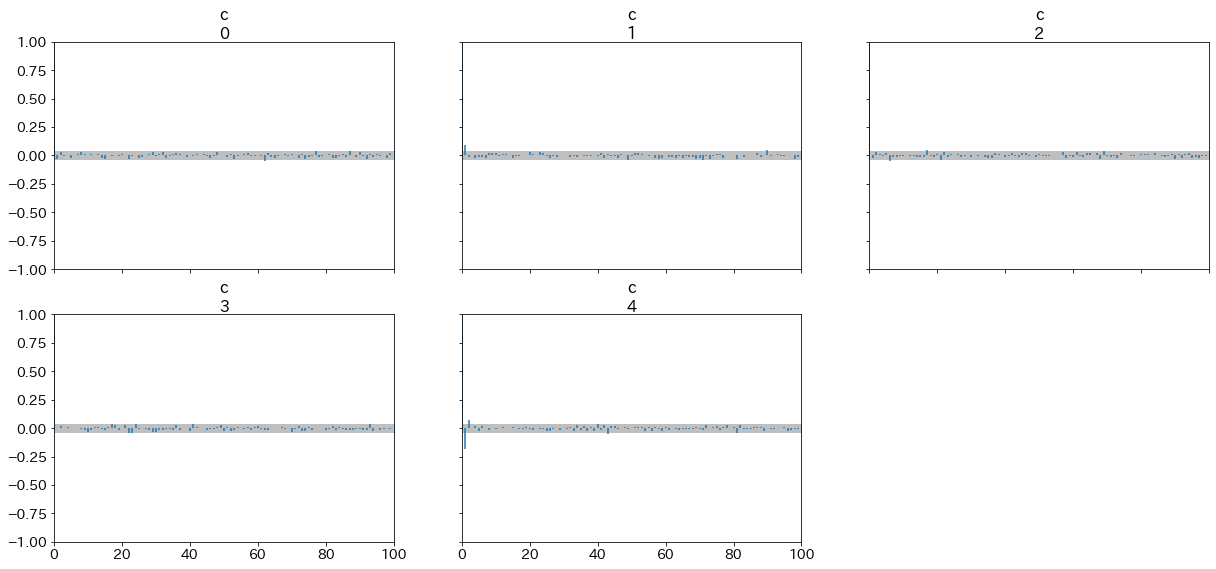

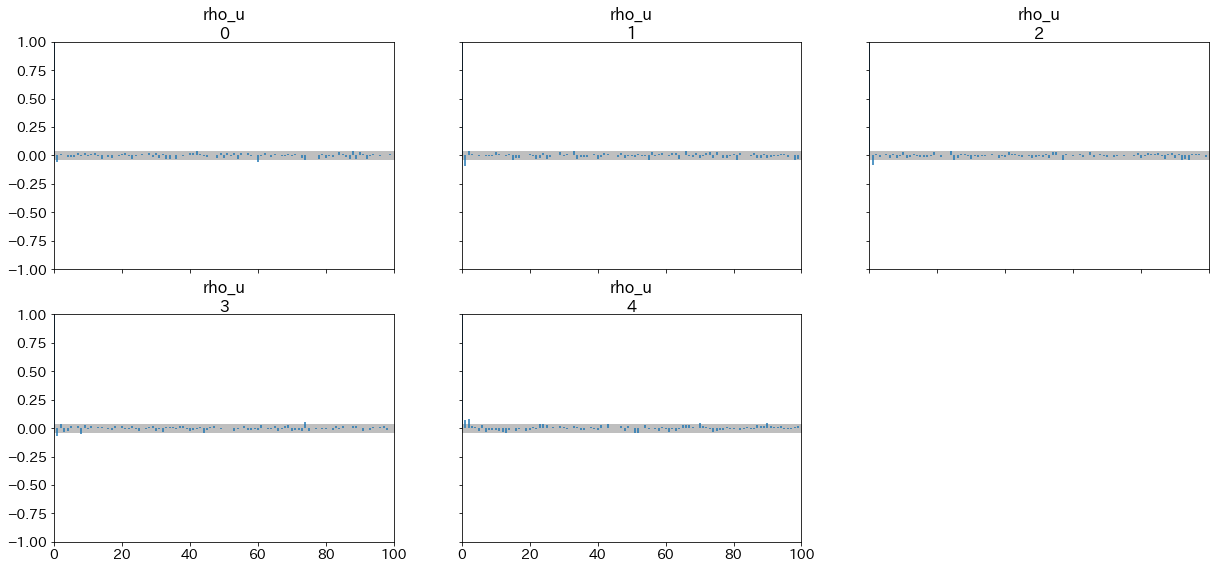

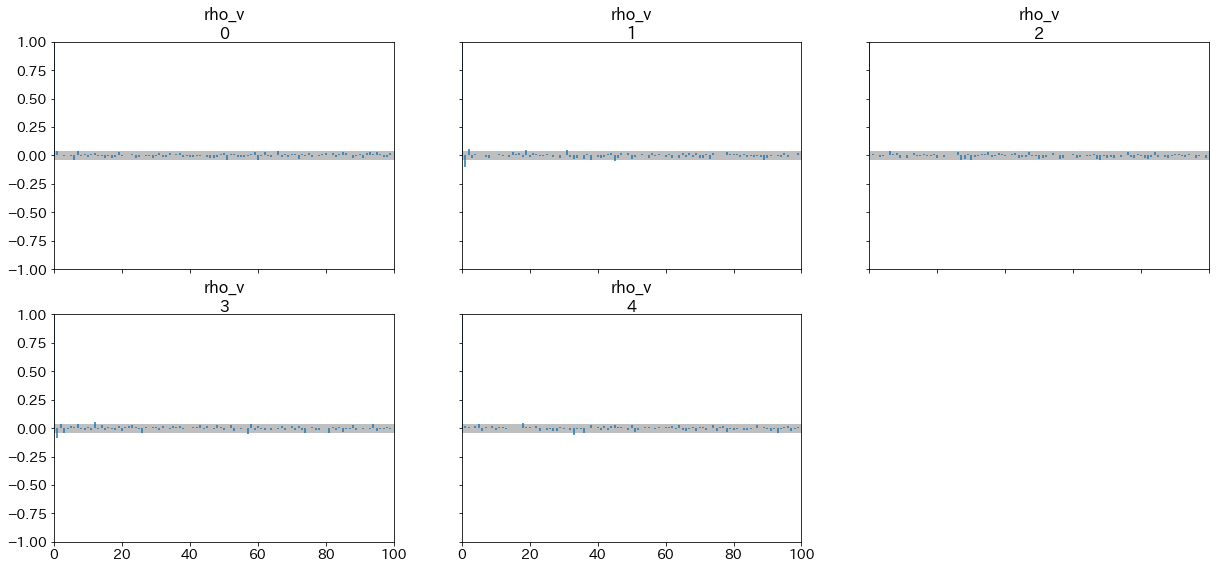

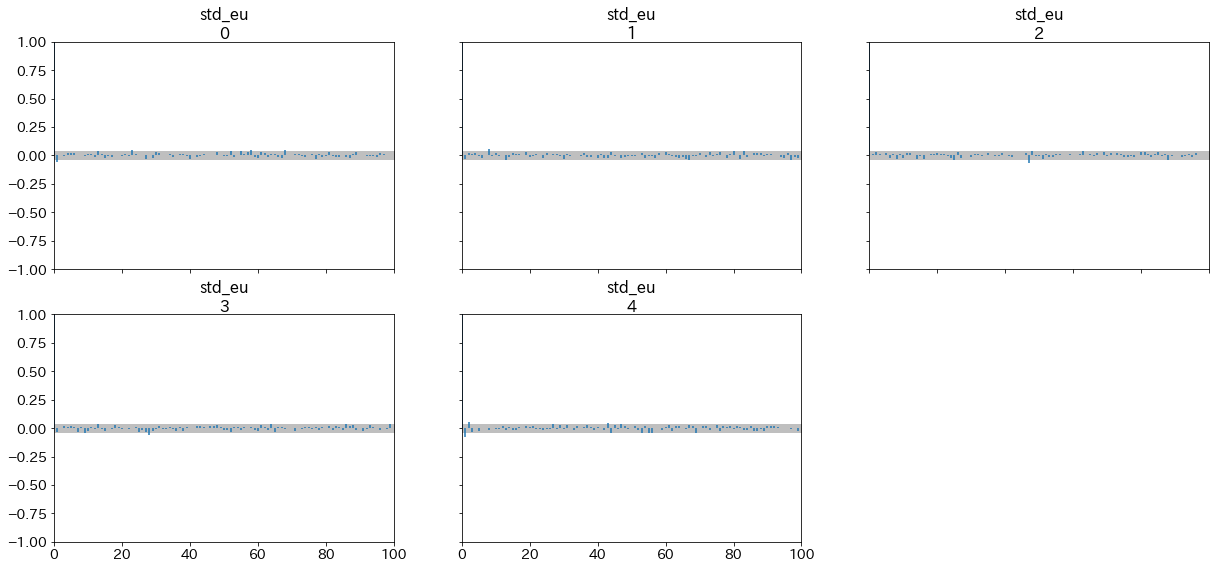

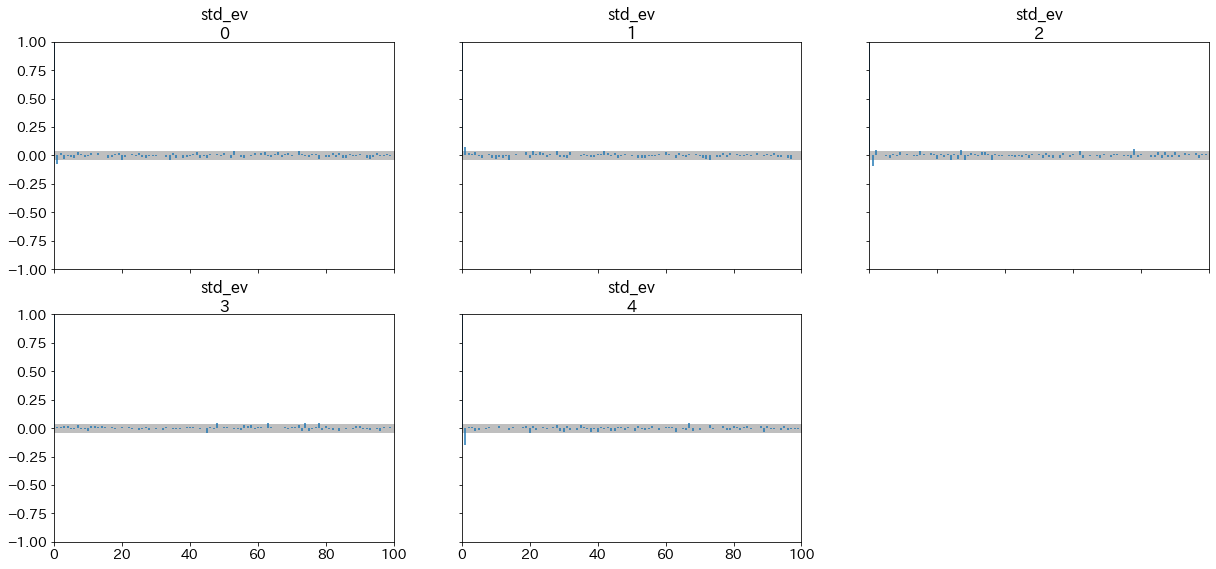

In [24]:
az.plot_autocorr(trace, var_names=["a"])
az.plot_autocorr(trace, var_names=["c"])
az.plot_autocorr(trace, var_names=["rho_u"])
az.plot_autocorr(trace, var_names=["rho_v"])
az.plot_autocorr(trace, var_names=["std_eu"])
az.plot_autocorr(trace, var_names=["std_ev"])
pass

#### 推定値，信頼区間，信用区間

In [25]:
mean_lst = []
median_lst = []
mode_lst = []
low_hdi = []
high_hdi = []

for i in range(2,7+1):
    
    trace_ = trace.to_dataframe().iloc[:,i]
    
    mom = three_moments( trace_ )
    mean_lst.append( mom[0] )
    median_lst.append( mom[1] )
    mode_lst.append( mom[2] )
    
    hdi = az.hdi(trace_.to_numpy(), hdi_prob=0.90)
    low_hdi.append( hdi[0] )
    high_hdi.append( hdi[1] )

In [26]:
pd.options.display.float_format = '{:.4f}'.format
results = pd.DataFrame({'MLE': res_mle.params,
                        'ci_low':res_mle.conf_int(0.1)[0],
                        'ci_high':res_mle.conf_int(0.1)[1],
                        'BE-mean':mean_lst, 'BE-median':median_lst, 'BE-mode':mode_lst,
                        'hdi_low':low_hdi, 'hdi_high':high_hdi},
                        index=res_mle.params.index)
results

,MLE,ci_low,ci_high,BE-mean,BE-median,BE-mode,hdi_low,hdi_high
c,2.0691,1.3988,2.7395,2.0688,2.0680,2.0611,1.9154,2.2258
a,0.1686,0.0802,0.2570,0.1684,0.1684,0.1684,0.1532,0.1849
rho_u,0.7667,0.6834,0.8500,0.7661,0.7662,0.7602,0.6838,0.8474
rho_v,0.0680,-0.0618,0.1979,0.0681,0.0683,0.0728,-0.0687,0.2100
std_eu,0.0113,0.0102,0.0125,0.0114,0.0114,0.0113,0.0103,0.0124
std_ev,0.0046,0.0042,0.0050,0.0046,0.0046,0.0046,0.0042,0.0050


## Stochastic Simulation

### `stochastic_sim()`関数

In [27]:
def stochastic_sim(a, c, rhou, rhov, eustd, evstd, hhat, n=100):

    """引数
        n: シミュレーションの回数（デフォルト：100）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
        eustd: 需要ショックの分散（デフォルト：eu_std）
        evstd: 供給ショックの分散（デフォルト：ev_std）
    戻り値：
        y, p, u, vのDataFrame
        """
    # ========== pの差分方程式の右辺 ==========
    def price_func(p, u, v):
        h = 1/(1+a*c)
        return h*p + h*(a*u + v)

    # ========== 結果を格納するリストの作成 ==========
    y_list = []
    p_list = []
    u_list = []
    v_list = []
    
    # ========== forループのアップデート用変数 ==========
    # 式(2b)は差分方程式ではないのでyのアップデート用の変数は必要ない
    # 最初は定常状態に設定
    p = 0
    u = 0
    v = 0

    # ========== ループ計算 ==========
    for _ in range(n):
        # ADのショック項
        u = rhou * u + rng.normal(0, eustd)

        # ASのショック項
        v = rhov * v + rng.normal(0, evstd)
        
        p = price_func(p, u, v)
        y = - c*p + u
            
        y_list.append(y)
        p_list.append(p)
        u_list.append(u)
        v_list.append(v)
            
    # 変数の辞書の作成
    dic = {'y':y_list, 'p':p_list, 'u':u_list, 'v':v_list}

    # ========== 結果の計算 ==========

    df = pd.DataFrame(dic)

    result = {}

    for v in ['y','p']:
        result[v+'_std'] = df[v].std()

    for v in ['y','p']:
        result[v+'_autocorr'] = df[v].autocorr()
    
    result['yp_corr'] = df[['y', 'p']].corr().iloc[0,1]

    yp_corr_12 = []

    for n in range(0,12+1):
        df['p_shift'] = df['p'].shift(-n)
        corr = df[['y', 'p_shift']].corr().iloc[0,1]
        yp_corr_12.append(corr)

    # DataFrameを返す

    print(f'hhat: {hhat:.3f}')
    return pd.DataFrame(result, index=['4AR1']), pd.DataFrame({'yp_corr_12': yp_corr_12})

### `MLE`

In [28]:
hhat = 1/( 1+results['BE-mean']['a']*results['BE-mean']['c'] )

sim_mle = stochastic_sim(a=results['MLE']['a'],
                         c=results['MLE']['c'],
                         rhou=results['MLE']['rho_u'],
                         rhov=results['MLE']['rho_v'],
                         eustd=results['MLE']['std_eu'],
                         evstd=results['MLE']['std_ev'],
                         hhat=hhat,
                         n=1_000_000)

hhat: 0.742


### `BE-mean`

In [29]:
hhat = 1/( 1+results['BE-mean']['a']*results['BE-mean']['c'] )

sim_mean = stochastic_sim(a=results['BE-mean']['a'],
                          c=results['BE-mean']['c'],
                          rhou=results['BE-mean']['rho_u'],
                          rhov=results['BE-mean']['rho_v'],
                          eustd=results['BE-mean']['std_eu'],
                          evstd=results['BE-mean']['std_ev'],
                          hhat=hhat,
                          n=1_000_000)

hhat: 0.742


### `BE-median`

In [30]:
hhat = 1/( 1+results['BE-median']['a']*results['BE-median']['c'] )

sim_median = stochastic_sim(a=results['BE-median']['a'],
                            c=results['BE-median']['c'],
                            rhou=results['BE-median']['rho_u'],
                            rhov=results['BE-median']['rho_v'],
                            eustd=results['BE-median']['std_eu'],
                            evstd=results['BE-median']['std_ev'],
                            hhat=hhat,
                            n=1_000_000)

hhat: 0.742


### `BE-mode`

In [31]:
hhat = 1/( 1+results['BE-mode']['a']*results['BE-mode']['c'] )

sim_mode = stochastic_sim(a=results['BE-mode']['a'],
                          c=results['BE-mode']['c'],
                          rhou=results['BE-mode']['rho_u'],
                          rhov=results['BE-mode']['rho_v'],
                          eustd=results['BE-mode']['std_eu'],
                          evstd=results['BE-mode']['std_ev'],
                          hhat=hhat,
                          n=1_000_000)

hhat: 0.742


### Compare Results

In [32]:
df_results = pd.concat([df[0],sim_mle[0],sim_mean[0],sim_median[0],sim_mode[0]]);
df_results.index = ['Data', 'MLE', 'BE-mean', 'BE-median', 'BE-mode']
df_results

,y_std,p_std,y_autocorr,p_autocorr,yp_corr
Data,0.0148,0.0070,0.6809,0.8293,-0.2340
MLE,0.0151,0.0082,0.6624,0.8801,-0.4013
BE-mean,0.0152,0.0083,0.6616,0.8809,-0.4022
BE-median,0.0151,0.0083,0.6608,0.8811,-0.4020
BE-mode,0.0151,0.0082,0.6624,0.8800,-0.4098


<AxesSubplot: >

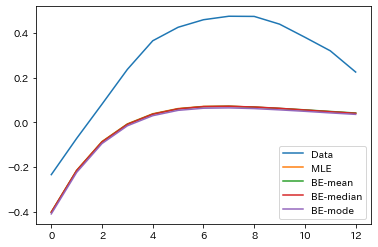

In [33]:
yp_corr_12 = pd.DataFrame({'Data':df[1].to_numpy().ravel(),
                           'MLE':sim_mle[1].to_numpy().ravel(),
                           'BE-mean':sim_mean[1].to_numpy().ravel(),
                           'BE-median':sim_median[1].to_numpy().ravel(),
                           'BE-mode':sim_mode[1].to_numpy().ravel()})
yp_corr_12.plot()

違いは大きくない．

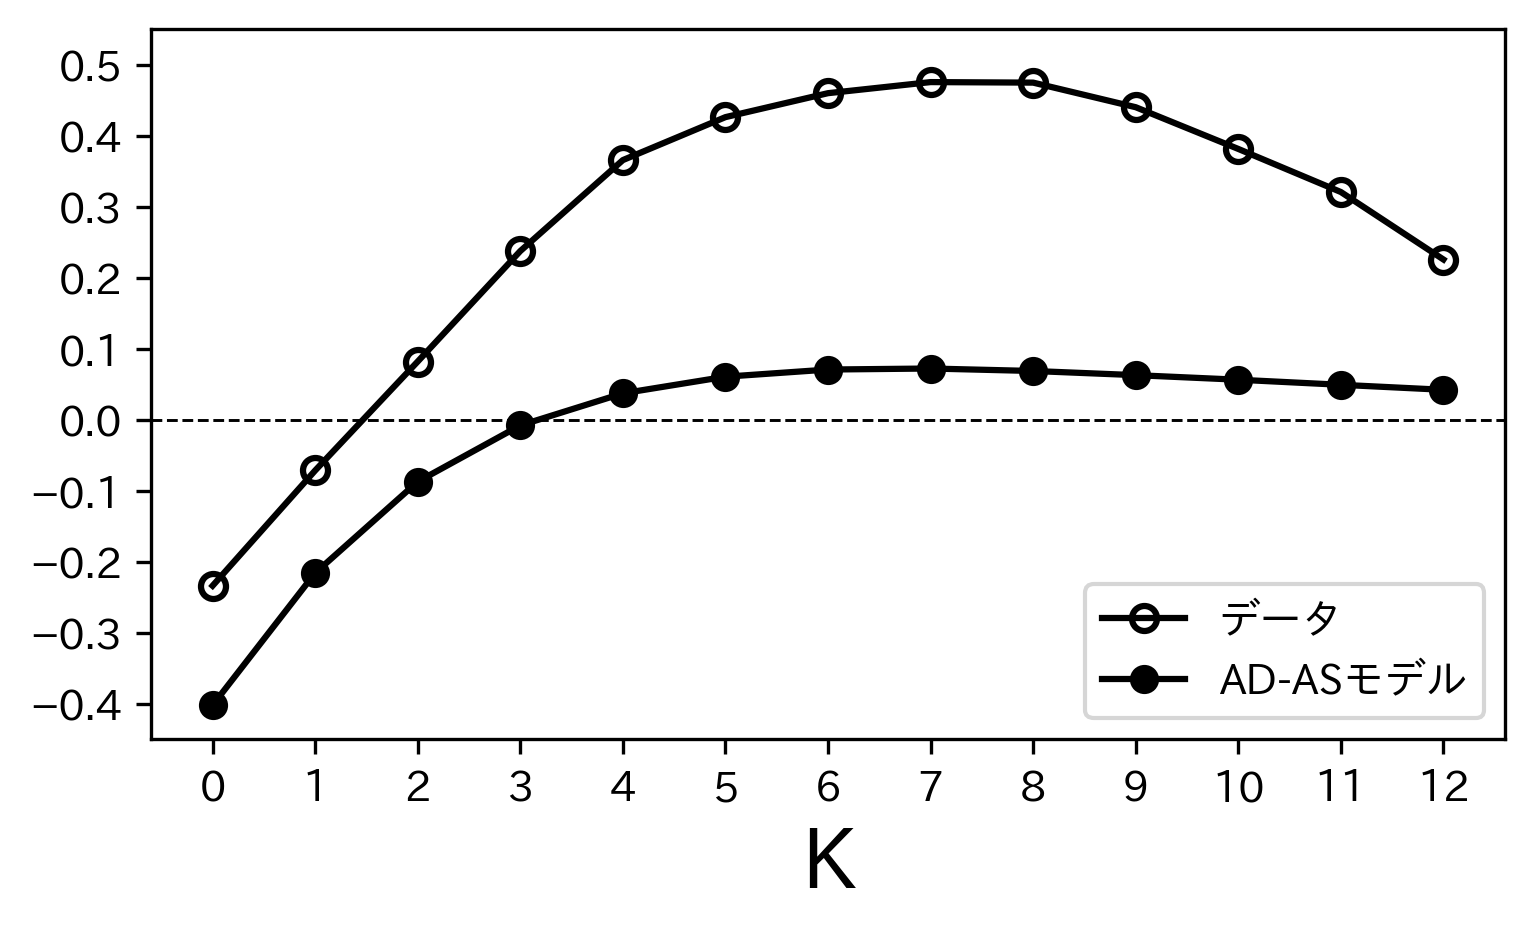

In [34]:
fig, ax = plt.subplots(figsize=(5,3), dpi=300, constrained_layout=True)
ax.plot('Data', data=yp_corr_12, color='k', marker='o',
        markerfacecolor='none', markeredgewidth=1.5)
ax.plot('BE-mean', data=yp_corr_12, color='k', marker='o')
ax.axhline(0, color='k', lw=0.7, linestyle='--')
ax.set_xlabel('K', fontsize=20)
ax.set_xticks([i for i in range(12+1)])
ax.set_ylim(-0.45, 0.55)
ax.set_yticks(np.arange(-0.4, 0.55, 0.1))
ax.legend(['データ','AD-ASモデル'], loc='lower right')
pass

## 定量的問い（状態変数`ut`と`vt`を使う）

以下の計算では`BE-mean`の値のみを使う．

In [35]:
ahat = results['BE-mean']['a']
chat = results['BE-mean']['c']
rho_u = results['BE-mean']['rho_u']
rho_v = results['BE-mean']['rho_v']
std_eu = results['BE-mean']['std_eu']
std_eu = results['BE-mean']['std_ev']
hhat = 1/( 1+ahat*chat )

### `ut`と`vt`の相関

In [36]:
uv = mod_mle.smooth(results['BE-mean']).states.smoothed
uv.columns = ['ut','vt']

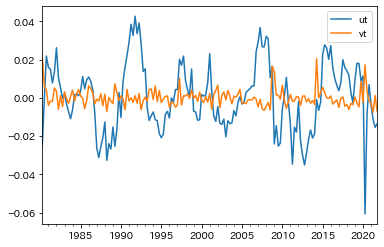

In [37]:
uv.plot()
pass

In [38]:
uv.std()

ut   0.0177
vt   0.0046
dtype: float64

In [39]:
uv.loc[:,'ut'].autocorr(), uv.loc[:,'vt'].autocorr()

(0.7654168728186564, 0.0635213484199966)

↑↑↑　`rho_u`と`rho_v`の推定値と殆ど同じ

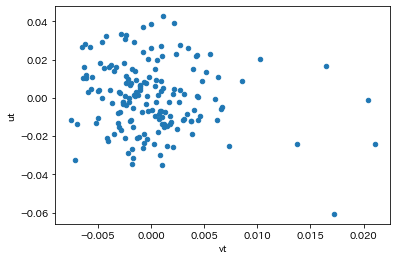

In [40]:
uv.plot('vt', 'ut', kind='scatter')
pass

`ut` and `vt` are uncorrelated.

In [41]:
uv.cov()

,ut,vt
ut,0.0003,-0.0000
vt,-0.0000,0.0000


↑↑↑　`ut`と`vt`は殆ど無相関

In [90]:
res_uv = smf.ols('ut ~ vt', data=uv).fit()

In [91]:
print(res_uv.get_robustcov_results(cov_type='HAC', maxlags=1, use_t=True).summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                     ut   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.021
No. Observations:                 167   F-statistic:                     3.061
Covariance Type:                  HAC   Prob (F-statistic):             0.0821
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.002      0.202      0.841      -0.003       0.004
vt            -0.6244      0.357     -1.749      0.082      -1.329       0.080

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction


5%水準で帰無仮説を棄却できない　→  無相関

### 結果

In [44]:
ut = uv.loc[:,'ut']
vt = uv.loc[:,'vt']

In [45]:
# Cov(ut,vt) = 0

# 式(*y)の分子
numerator_y = ut.var()
# 式(*y)の分母
denominator_y = ut.var() + chat**2*vt.var()

ad_shock_on_y = numerator_y / denominator_y
print(f'GDPの％乖離の{100*ad_shock_on_y:.1f}％は総需要ショックに起因する。'  )

GDPの％乖離の77.4％は総需要ショックに起因する。


In [46]:
# Cov(ut,vt) != 0

# 式(*y)の分子
numerator_y = ut.var() - chat*np.cov(ut,vt)[0,1]
# 式(*y)の分母
denominator_y = ut.var() + chat**2*vt.var() - 2*chat*np.cov(ut,vt)[0,1]

ad_shock_on_y = numerator_y / denominator_y
print(f'GDPの％乖離の{100*ad_shock_on_y:.1f}％は総需要ショックに起因する。'  )

GDPの％乖離の74.2％は総需要ショックに起因する。


In [49]:
# Cov(ut,vt) = 0

# 式(*p)の分子
numerator_p = ahat**2*ut.var()
# 式(*p)の分母
denominator_p = ahat**2*ut.var() + vt.var()

ad_shock_on_p = numerator_p / denominator_p
print(f'価格水準の％乖離の{100*ad_shock_on_p:.1f}％は需要ショックに起因する。'  )

価格水準の％乖離の29.4％は需要ショックに起因する。


In [50]:
# Cov(ut,vt) != 0

# 式(*p)の分子
numerator_p = ahat**2*ut.var() + ahat*np.cov(ut,vt)[0,1]
# 式(*p)の分母
denominator_p = ahat**2*ut.var() + vt.var() + 2*ahat*np.cov(ut,vt)[0,1]

ad_shock_on_p = numerator_p / denominator_p
print(f'価格水準の％乖離の{100*ad_shock_on_p:.1f}％は需要ショックに起因する。'  )

価格水準の％乖離の25.8％は需要ショックに起因する。


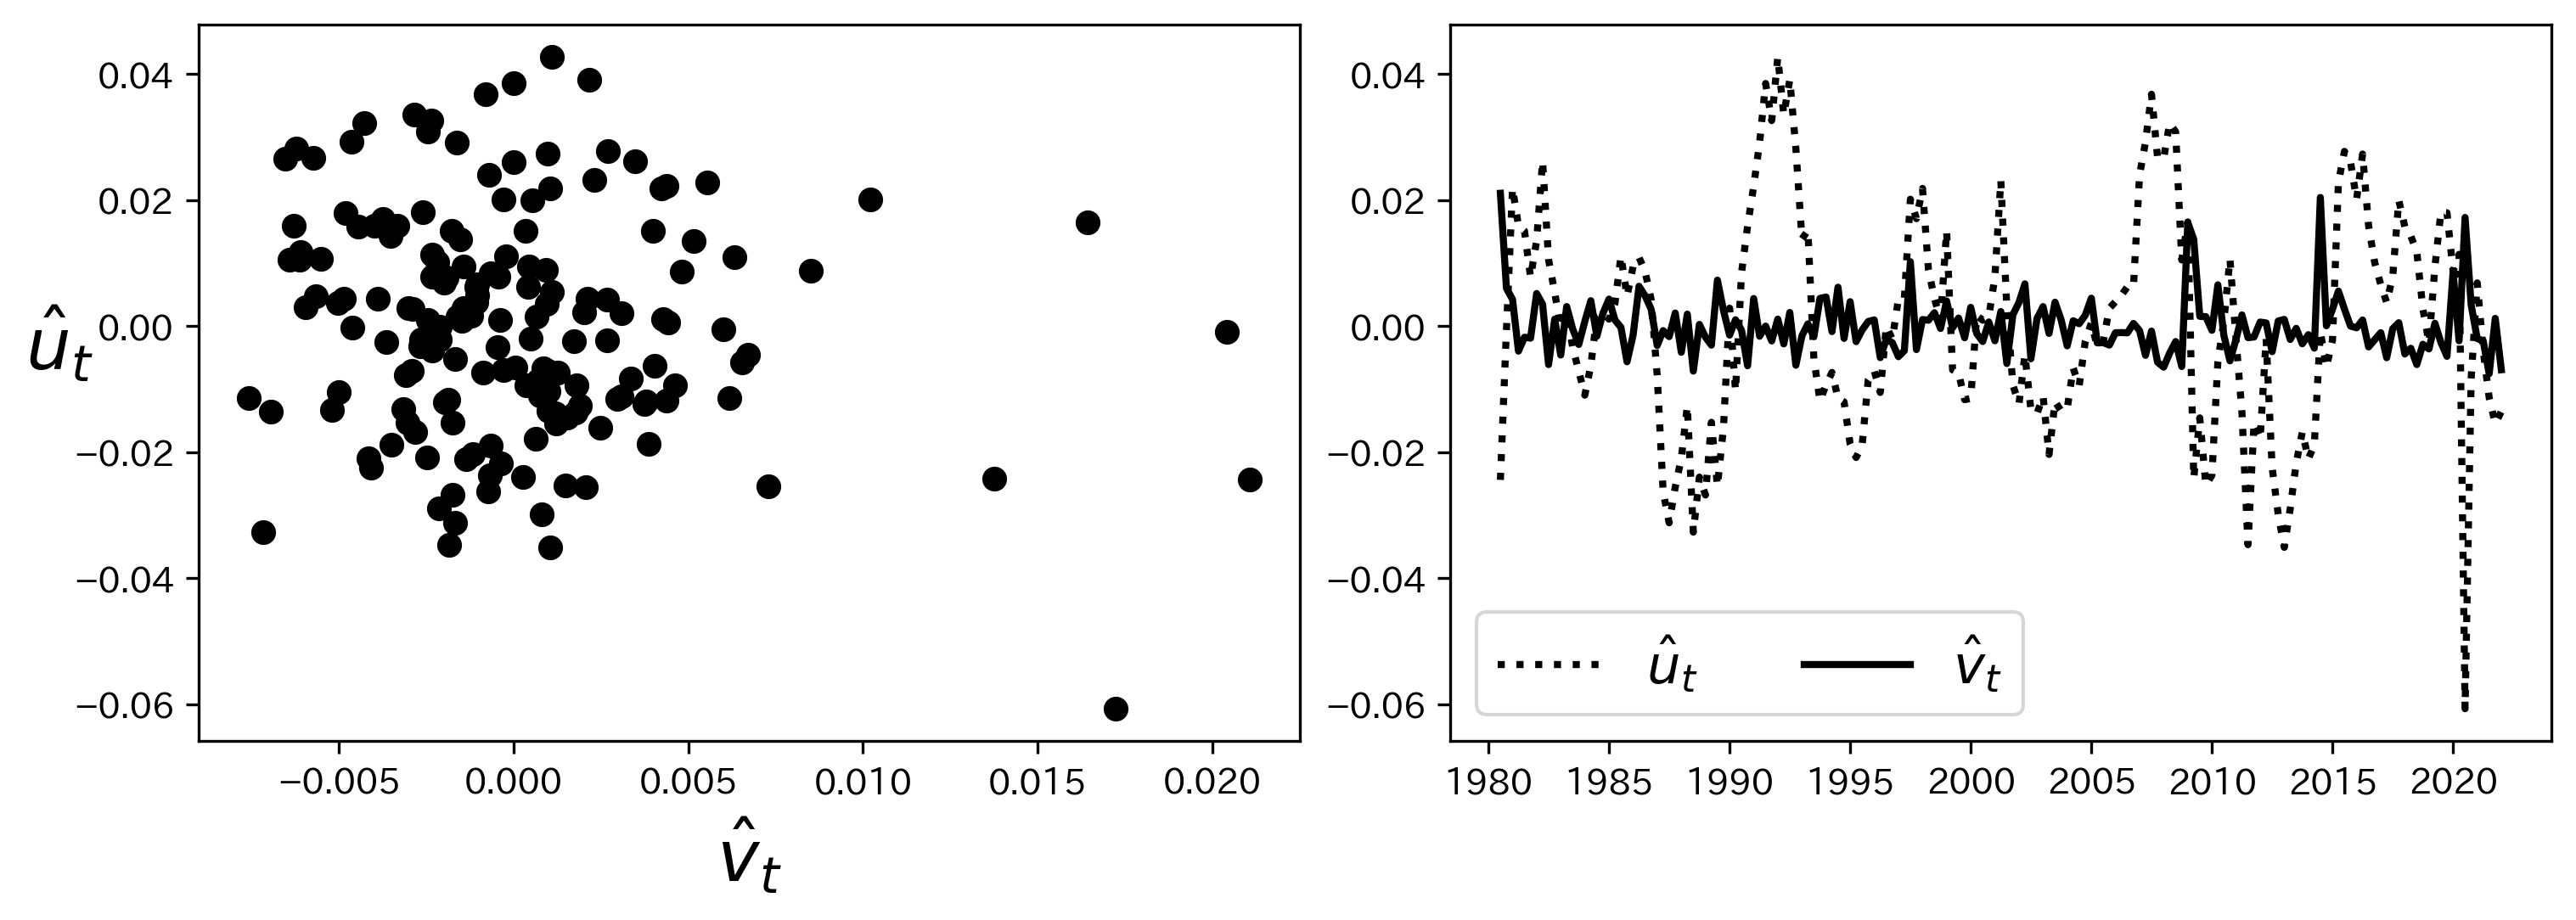

In [51]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5), constrained_layout=True, dpi=300)
ax[1].plot('ut', data=uv, label=r'$\hat{u}_t$', linestyle=':', lw='2', color='k')
ax[1].plot('vt', data=uv, label=r'$\hat{v}_t$', linestyle='-', lw='2', color='k')
ax[0].scatter('vt', 'ut', data=uv, color='k')
ax[1].legend(fontsize=15, ncol=2)
ax[0].set_xlabel(r'$\hat{v}_t$', size=20)
ax[0].set_ylabel(r'$\hat{u}_t$', size=20, rotation=0)
pass

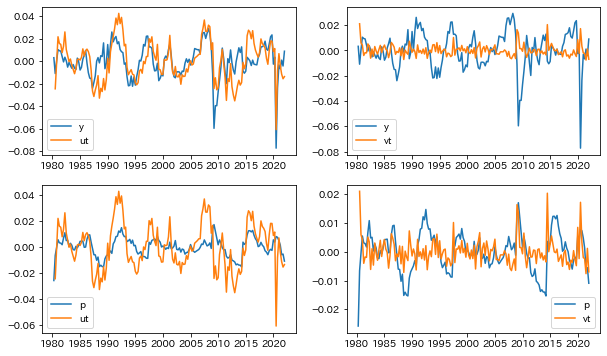

In [52]:
fig, ax = plt.subplots(2,2, figsize=(10,6))
ax[0,0].plot('y', data=data)
ax[0,0].plot('ut', data=uv)
ax[0,1].plot('y', data=data)
ax[0,1].plot('vt', data=uv)
ax[1,0].plot('p', data=data)
ax[1,0].plot('ut', data=uv)
ax[1,1].plot('p', data=data)
ax[1,1].plot('vt', data=uv)
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
pass

## Forecast Errors `N` Period Ahead

### Shocks on `y`

行列`C`の`(0,1)`成分を返す関数

In [53]:
def C01(k, chat=chat, hhat=hhat):
    
    C = np.array([[0, -chat*hhat],
                  [0, hhat]])
    
    if k == 1:
        return C[0,1]
        
    elif k >= 2:
        return multi_dot( [C]*int(k) )[0,1]
        
    else:
        raise ValueError('n must be larger than 1')

$\Phi(T)$を返す関数

In [54]:
def Phi(T, chat=chat, hhat=hhat):
    
    C01_lst =[]
    
    if T >= 1:
        
        for i in range(1,T+1):
            C01_lst.append(C01(i)**2)
            
        return sum(C01_lst)
    
    else:
        raise ValueError('n must be larger than 1')

In [55]:
def AD_shock_on_y(T, ut=ut, vt=vt, chat=chat):
    
    numerator = ( 1+ahat**2*Phi(T) )*ut.var()
    denominator = numerator + ( chat**2+Phi(T) )*vt.var()
    return numerator/denominator

AD_shock_on_y(100)

0.6395476098291505

In [56]:
ad_shock_on_y_dict = {}
as_shock_on_y_dict = {}

T = 12

for i in range(1,T+1):
    ad_shock_on_y_dict[i] = AD_shock_on_y(i)
    as_shock_on_y_dict[i] = 1-AD_shock_on_y(i)

print(AD_shock_on_y(50))

0.6395476098291606


<AxesSubplot: >

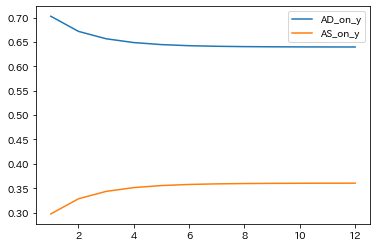

In [57]:
df_shocks_ci = pd.DataFrame({'AD_on_y':ad_shock_on_y_dict.values(),
                             'AS_on_y':as_shock_on_y_dict.values()},
                            index=range(1,T+1))
df_shocks_ci.plot()

As $T\rightarrow\infty$

In [58]:
def AD_shock_on_y_LR(ut=ut, vt=vt, chat=chat, hhat=hhat):
    
    Phi_LR = chat**2 *hhat**2/(1-hhat**2)
    
    numerator = ( 1+ahat**2*Phi_LR )*ut.var()
    denominator = numerator + ( chat**2+Phi_LR )*vt.var()
    return numerator/denominator

AD_shock_on_y_LR()

0.6395476098291505

### Bootstrap Confidence Interval: `y`

In [59]:
def bootstrap_difference_of_variance_shock_on_y(T, uv, n_iterations=1000):
    """
    Calculate delta* for each bootstrapped calculation
    where delta* is defined in class24-prep-a.pdf
    """

    ad_shock_on_y_diff_lst = []
    as_shock_on_y_diff_lst = []
    
    for _ in range(n_iterations):
        uv_ = uv.sample(frac=1, replace=True)
        uu = uv_['ut']
        vv = uv_['vt']

        ad_diff = AD_shock_on_y(T, ut=uu, vt=vv) - ad_shock_on_y_dict[T]
        as_diff = ( 1-AD_shock_on_y(T, ut=uu, vt=vv) ) - as_shock_on_y_dict[T]
        
        ad_shock_on_y_diff_lst.append( ad_diff )
        as_shock_on_y_diff_lst.append( as_diff )

    return {'AD':ad_shock_on_y_diff_lst, 'AS':as_shock_on_y_diff_lst}

# bootstrap_difference_of_variance_shock_on_y(1, uv, n_iterations=10)

In [60]:
CI_ad_on_y_95_lst = []
CI_as_on_y_95_lst = []
CI_ad_on_y_68_lst = []
CI_as_on_y_68_lst = []

for i in range(1,T+1):
    
    X = bootstrap_difference_of_variance_shock_on_y(i, uv, 10_000)

    ci_ad_95 = ad_shock_on_y_dict[i] - np.percentile(X['AD'], (2.5,97.5))
    ci_as_95 = as_shock_on_y_dict[i] - np.percentile(X['AS'], (2.5,97.5))
    ci_ad_68 = ad_shock_on_y_dict[i] - np.percentile(X['AD'], (16,84))
    ci_as_68 = as_shock_on_y_dict[i] - np.percentile(X['AS'], (16,84))
    
    CI_ad_on_y_95_lst.append( ci_ad_95.tolist() )
    CI_as_on_y_95_lst.append( ci_as_95.tolist() )
    CI_ad_on_y_68_lst.append( ci_ad_68.tolist() )
    CI_as_on_y_68_lst.append( ci_as_68.tolist() )

CI_ad_on_y_95_arr = np.array( CI_ad_on_y_95_lst )
CI_as_on_y_95_arr = np.array( CI_as_on_y_95_lst )
CI_ad_on_y_68_arr = np.array( CI_ad_on_y_68_lst )
CI_as_on_y_68_arr = np.array( CI_as_on_y_68_lst )

In [61]:
df_shocks_ci['ci_upper_ad_on_y_95'] = CI_ad_on_y_95_arr[:,0]
df_shocks_ci['ci_lower_ad_on_y_95'] = CI_ad_on_y_95_arr[:,1]
df_shocks_ci['ci_upper_ad_on_y_68'] = CI_ad_on_y_68_arr[:,0]
df_shocks_ci['ci_lower_ad_on_y_68'] = CI_ad_on_y_68_arr[:,1]

df_shocks_ci['ci_upper_ad_on_p_95'] = CI_as_on_y_95_arr[:,0]
df_shocks_ci['ci_lower_ad_on_p_95'] = CI_as_on_y_95_arr[:,1]
df_shocks_ci['ci_upper_ad_on_p_68'] = CI_as_on_y_68_arr[:,0]
df_shocks_ci['ci_lower_ad_on_p_68'] = CI_as_on_y_68_arr[:,1]

In [62]:
df_shocks_ci#.columns

,AD_on_y,AS_on_y,ci_upper_ad_on_y_95,ci_lower_ad_on_y_95,ci_upper_ad_on_y_68,ci_lower_ad_on_y_68,ci_upper_ad_on_p_95,ci_lower_ad_on_p_95,ci_upper_ad_on_p_68,ci_lower_ad_on_p_68
1,0.7026,0.2974,0.7912,0.6161,0.7455,0.6574,0.3839,0.2088,0.3426,0.2545
2,0.6716,0.3284,0.7627,0.5798,0.7177,0.6238,0.4202,0.2373,0.3762,0.2823
3,0.6565,0.3435,0.7483,0.5619,0.7029,0.6059,0.4381,0.2517,0.3941,0.2971
4,0.6487,0.3513,0.7439,0.5557,0.6951,0.5989,0.4443,0.2561,0.4011,0.3049
5,0.6445,0.3555,0.7389,0.5497,0.6903,0.5939,0.4503,0.2611,0.4061,0.3097
6,0.6423,0.3577,0.7348,0.5466,0.6893,0.5915,0.4534,0.2652,0.4085,0.3107
7,0.6410,0.3590,0.7365,0.5449,0.6873,0.5882,0.4551,0.2635,0.4118,0.3127
8,0.6404,0.3596,0.7331,0.5432,0.6868,0.5889,0.4568,0.2669,0.4111,0.3132
9,0.6400,0.3600,0.7367,0.5448,0.6879,0.5896,0.4552,0.2633,0.4104,0.3121
10,0.6398,0.3602,0.7347,0.5407,0.6871,0.5888,0.4593,0.2653,0.4112,0.3129


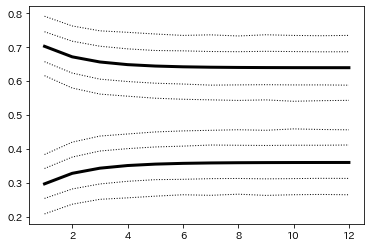

In [63]:
fig, ax = plt.subplots()

for i in df_shocks_ci.columns[:2]:
    ax.plot(i, data=df_shocks_ci, color='k', lw=3)
    
for i in df_shocks_ci.columns[2:]:
    ax.plot(i, data=df_shocks_ci, color='k', lw=1, linestyle=':')


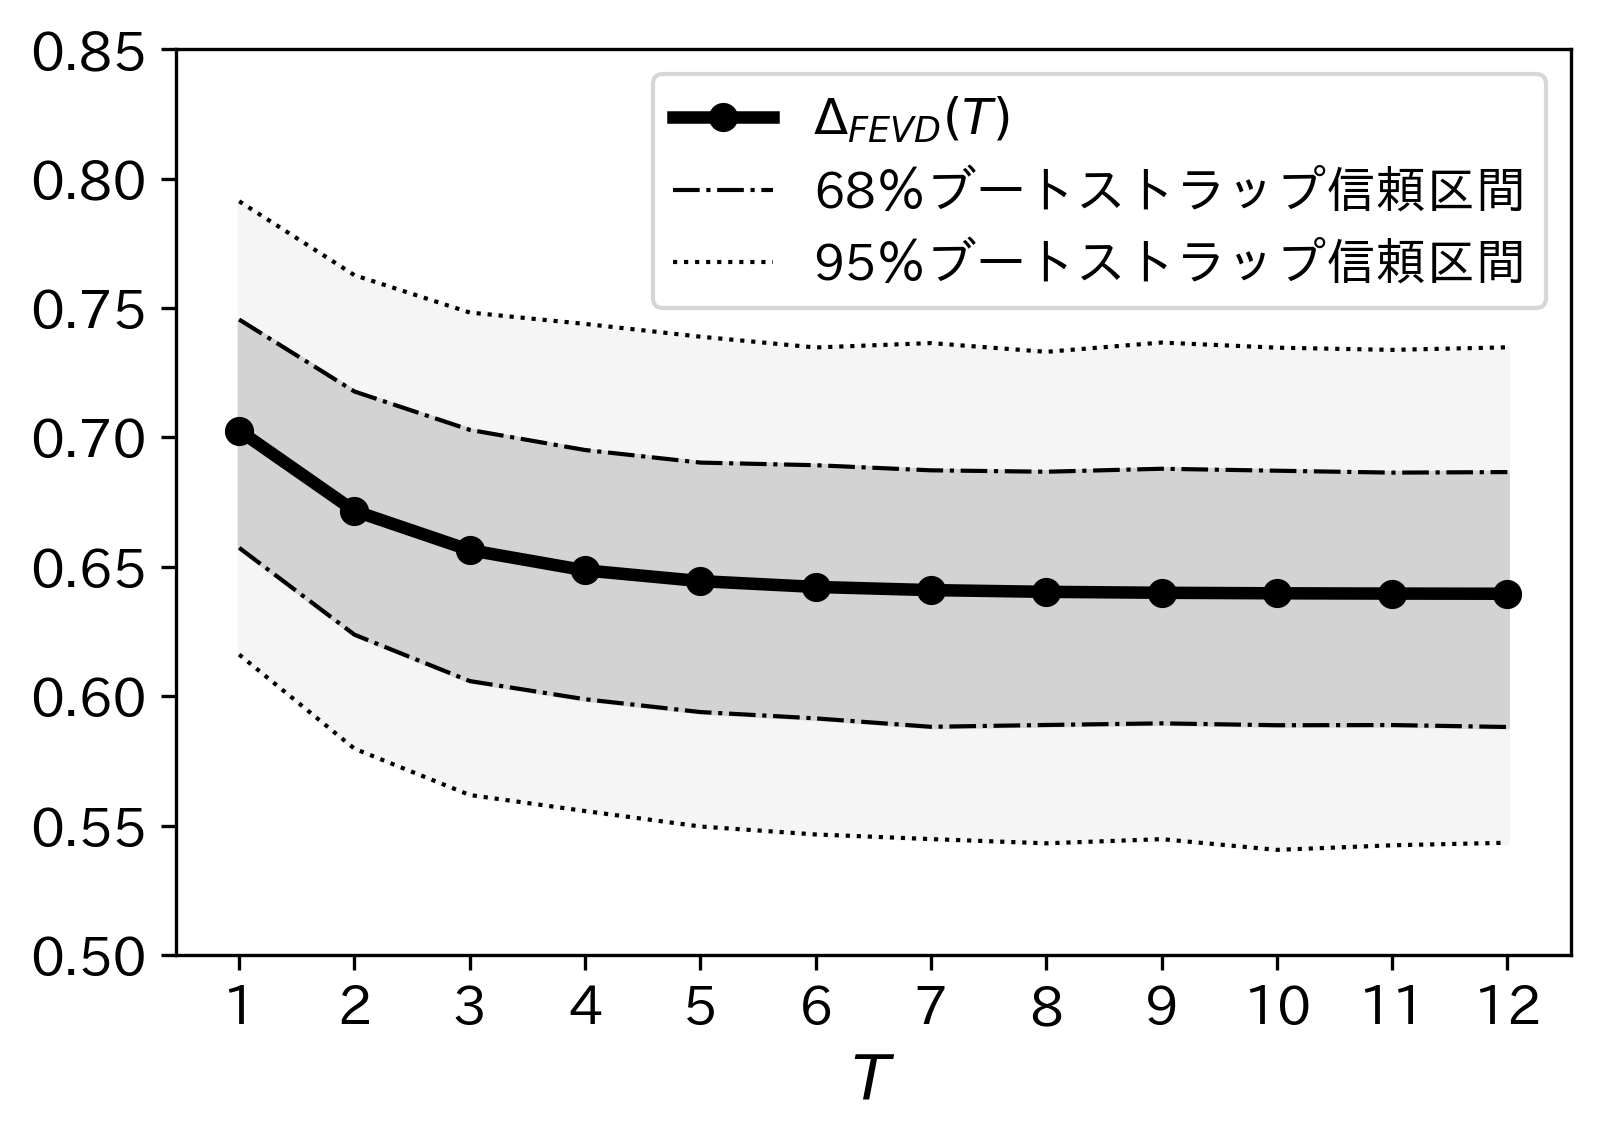

In [64]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot('AD_on_y', data=df_shocks_ci, color='k', lw=3, marker='o')
ax.plot('ci_upper_ad_on_y_68', data=df_shocks_ci, color='k', lw=1, linestyle='-.')
ax.plot('ci_upper_ad_on_y_95', data=df_shocks_ci, color='k', lw=1, linestyle=':')
ax.legend([r'$\Delta_{FEVD}(T)$','68％ブートストラップ信頼区間','95％ブートストラップ信頼区間'],
          loc='upper right', fontsize=12)
ax.plot('ci_lower_ad_on_y_68', data=df_shocks_ci, color='k', lw=1, linestyle='-.')
ax.plot('ci_lower_ad_on_y_95', data=df_shocks_ci, color='k', lw=1, linestyle=':')
ax.fill_between(df_shocks_ci.index,
                df_shocks_ci['ci_upper_ad_on_y_95'].to_numpy(),
                df_shocks_ci['ci_lower_ad_on_y_95'].to_numpy(),
                color='whitesmoke')
ax.fill_between(df_shocks_ci.index,
                df_shocks_ci['ci_upper_ad_on_y_68'].to_numpy(),
                df_shocks_ci['ci_lower_ad_on_y_68'].to_numpy(),
                color='lightgray')
ax.set_xlabel(r'$T$', fontsize=15)
ax.set_xticks(range(1,T+1))
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.set_ylim(0.5,0.85)
pass

### Shock on `p`

毎期同じになる。

## Historical Decomposition

`C01()`関数の修正版

In [65]:
def C01_modified(k, chat=chat, hhat=hhat):
    
    C = np.array([[0, -chat*hhat],
                  [0, hhat]])
    
    if k == 1:
        return 1
    
    elif k == 2:
        return C[0,1]
        
    elif k >= 3:
        return multi_dot( [C]*(k-1) )[0,1]
        
    else:
        raise ValueError('n must be larger than 1')
        
C01_modified = np.vectorize(C01_modified, otypes=[np.float64])

In [66]:
n = len(ut)

ad_shock_lst = []
as_shock_lst = []

for i in range(1,n):
    
    # AD・ASショックをarrayに変換
    ut_arr = ut[:i].to_numpy()
    vt_arr = vt[:i].to_numpy()
    
    # ウェイトを計算，np.flipは順番を逆にする
    Ck_arr = np.flip(
                     C01_modified( np.array(range(1,i+1)) )
                    )
    
    # ADショック
    ad_shock = ahat * hhat * Ck_arr * ut_arr
    # 最後の項だけ修正が必要
    ad_shock[-1] = ad_shock[-1] / ahat
    
    # ASショック
    as_shock = hhat * Ck_arr * vt_arr
    # 最後の項だけ修正が必要
    as_shock[-1] = -chat * as_shock[-1]
    
    # ショック項の合計を追加    
    ad_shock_lst.append( sum(ad_shock) )
    as_shock_lst.append( sum(as_shock) )

In [67]:
C01_modified(11)*data.loc['1980-06-30','p']

0.0006824130930321804

`DataFrame`の作成

In [68]:
df_shocks = pd.DataFrame({'ad_shocks':ad_shock_lst,
                          'as_shocks':as_shock_lst},
                          index=ut.index.tolist()[:n-1])

df_shocks['shocks'] = df_shocks['ad_shocks']+df_shocks['as_shocks']

最初は$p_t$の影響により乖離が残る

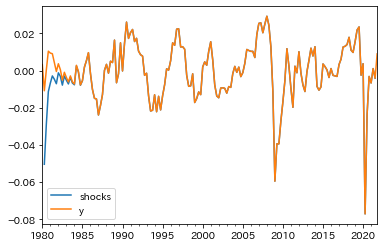

In [69]:
ax = df_shocks.loc[:,'shocks'].plot()
data.loc[:,'y'].plot(label='y', ax=ax)
ax.legend();

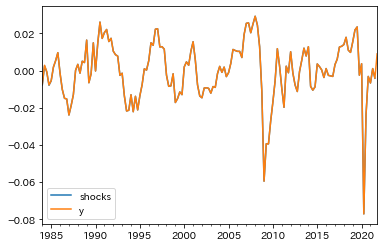

In [70]:
start = '1984-03-31'

ax = df_shocks.loc[start:,'shocks'].plot()
data.loc[start:,'y'].plot(label='y', ax=ax)
ax.legend();

1984年Q1からを使う

In [71]:
df_shocks = df_shocks.loc[start:,:]

In [72]:
df_plot = pd.merge(df_shocks, data[['y','p']], 
                   left_index=True, right_index=True,
                   how='left')
df_plot.head()

,ad_shocks,as_shocks,shocks,y,p
1984-03-31,-0.0031,-0.0045,-0.0076,-0.0072,0.0005
1984-06-30,0.0034,-0.0009,0.0025,0.0029,-0.0007
1984-09-30,0.0030,-0.0038,-0.0008,-0.0005,0.0013
1984-12-31,0.0015,-0.0093,-0.0079,-0.0077,0.0043
1985-03-31,0.0029,-0.0084,-0.0055,-0.0053,0.0043


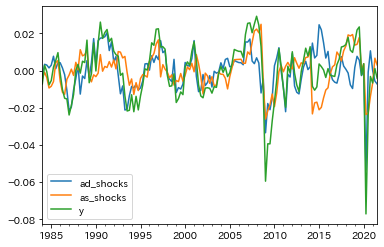

In [73]:
ax = df_plot[['ad_shocks','as_shocks','y']].plot()
ax.legend();

下で作成する図の横軸を作成

In [74]:
def quarter_lst_generater(df_plot):

    quarter_lst = []

    for i in range(len(df_plot)):

        year = df_plot.index[i].year

        month = df_plot.index[i].month

        if month == 3:
            quarter_lst.append( str(year)+' Q1' )

        elif month == 6:
            quarter_lst.append( str(year)+' Q2' )

        elif month == 9:
            quarter_lst.append( str(year)+' Q3' )

        else:
            quarter_lst.append( str(year)+' Q4' )
            
    return quarter_lst

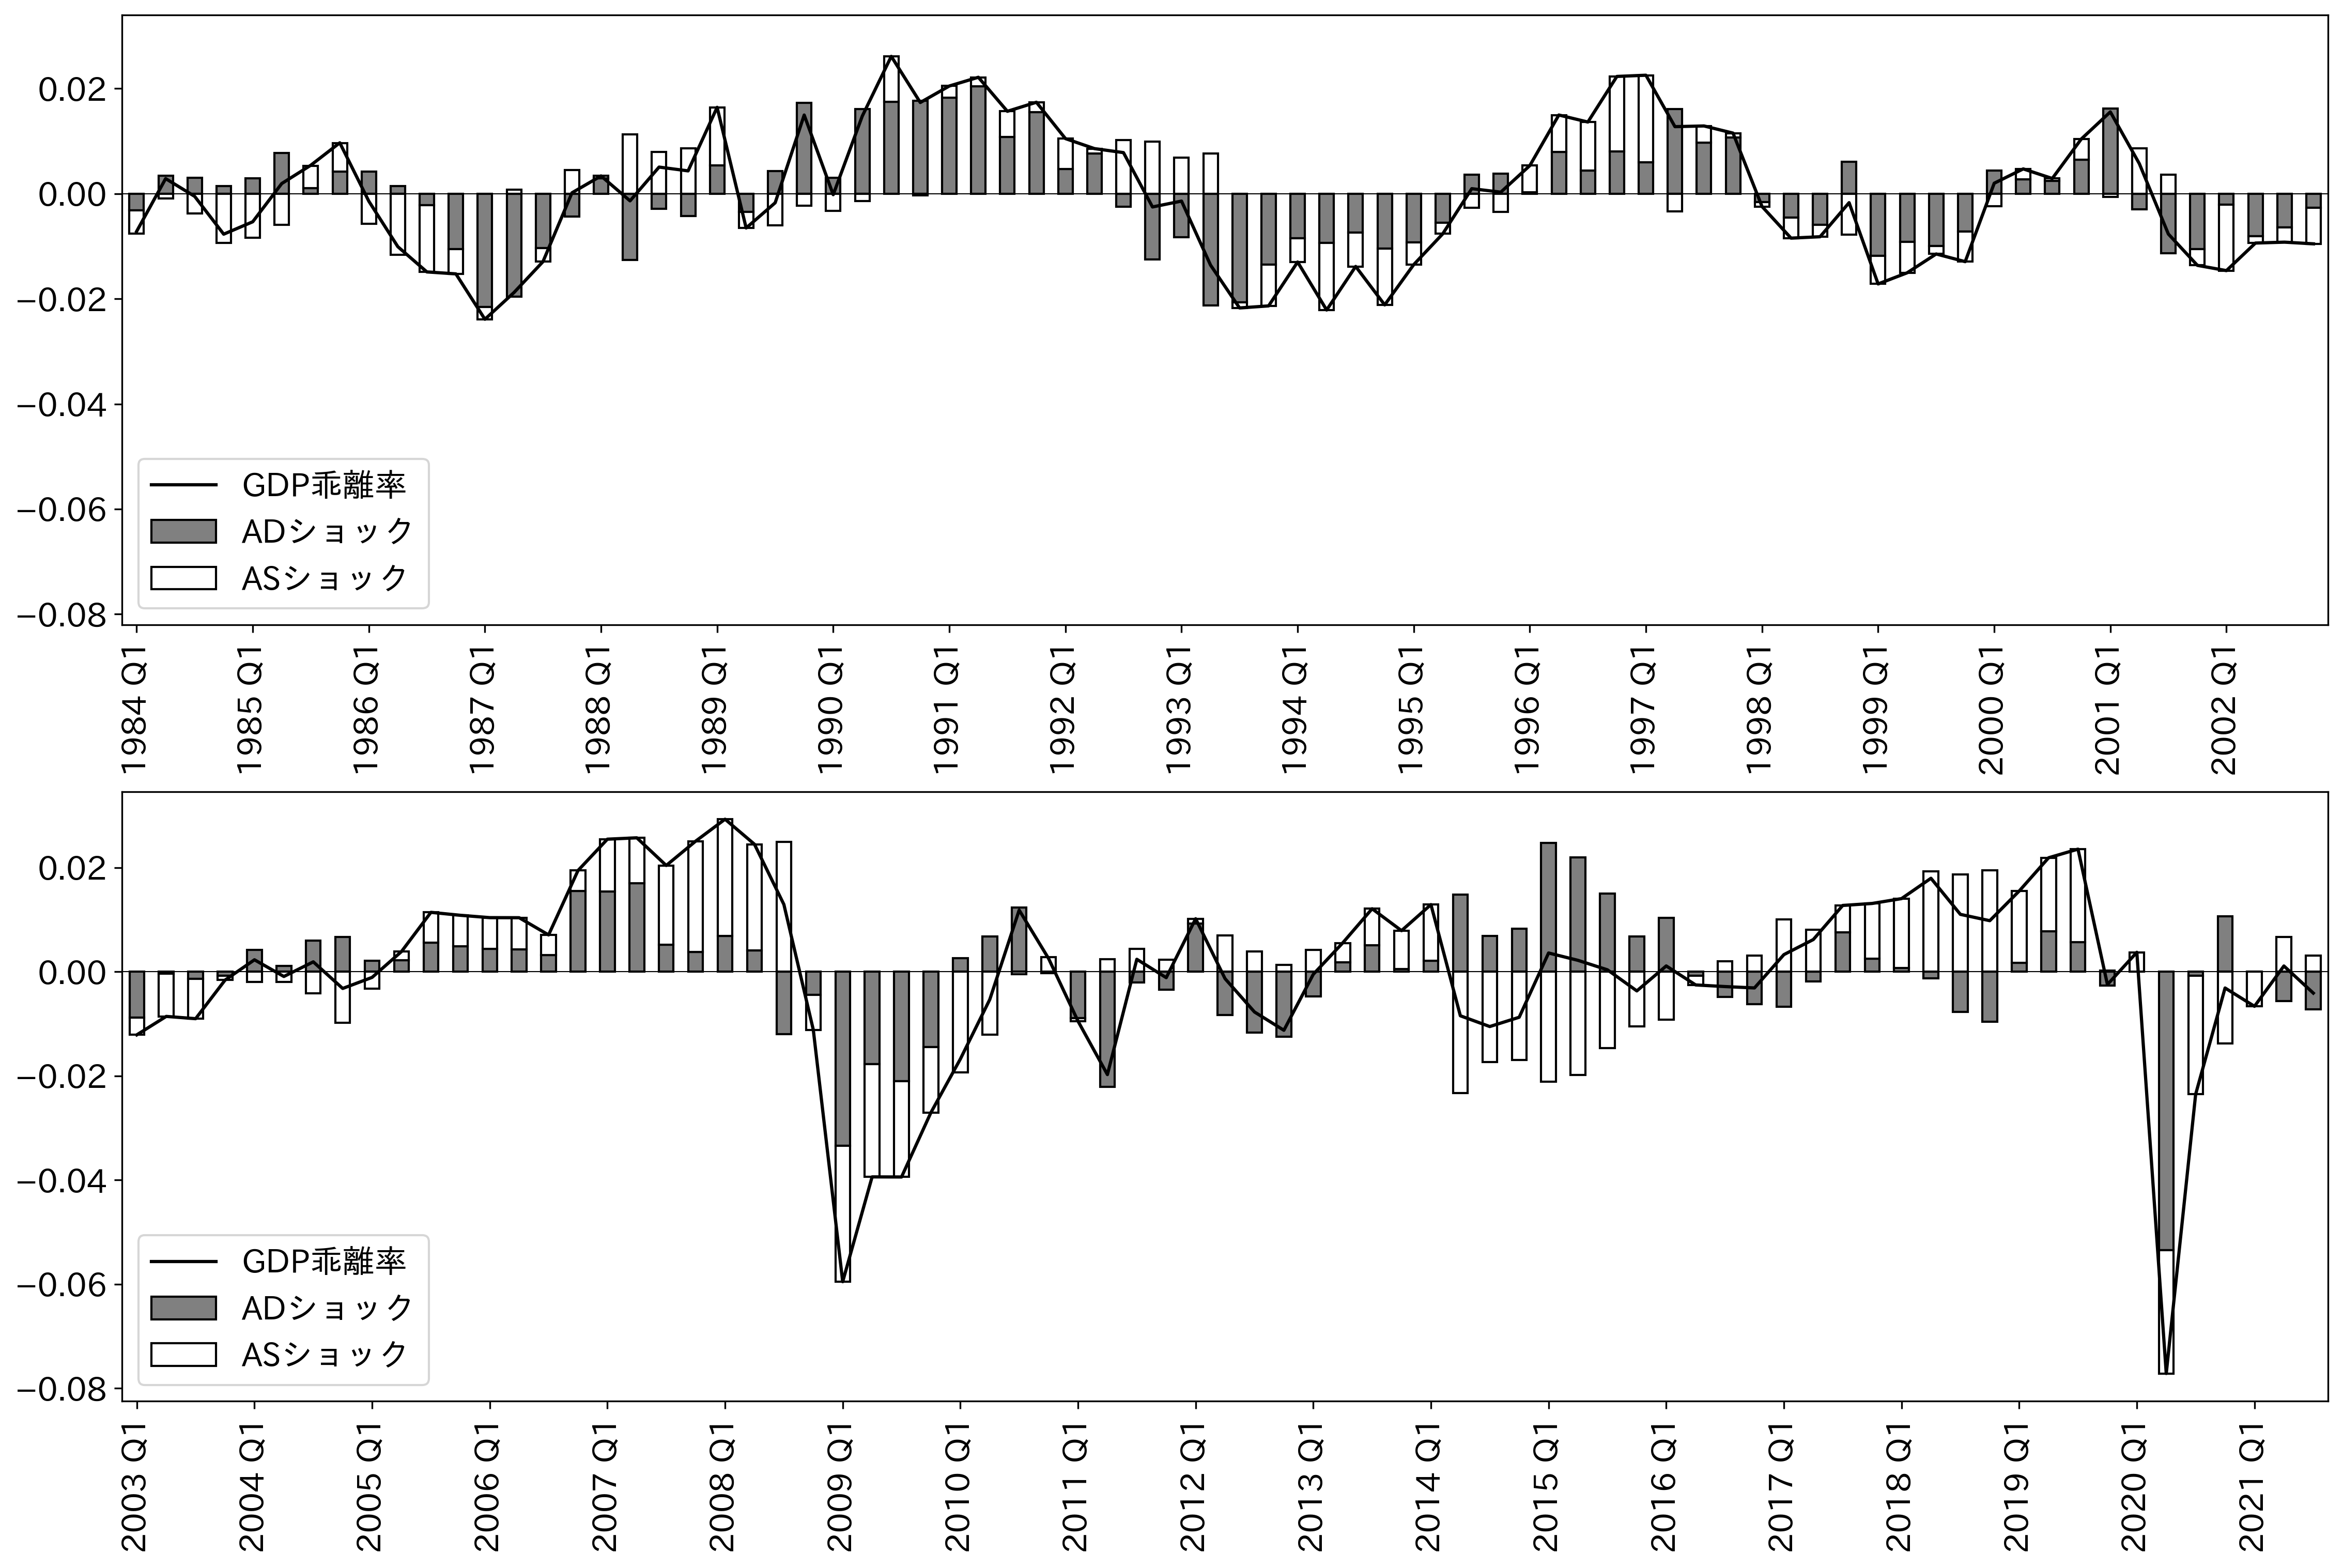

In [75]:
start0 = '1984-03-31'
# end0 = '1999-12-31'
# start1 = '2000-03-31'
end0 = '2002-12-31'
start1 = '2003-03-31'
end1 = '2021-09-30'

# 期間を決める
df_plot0 = df_plot.loc[start0:end0,:]
df_plot1 = df_plot.loc[start1:end1,:]

# 横軸の値
quarter_lst0 = quarter_lst_generater(df_plot0)
quarter_lst1 = quarter_lst_generater(df_plot1)
index0 = np.arange( len(df_plot0.index) )
index1 = np.arange( len(df_plot1.index) )

# 縦に２つの図
fig, ax = plt.subplots(2,1, figsize=(15,10), constrained_layout=True, dpi=300)

# 上の図 ---------------------------------------------
df_plot0[['ad_shocks','as_shocks']].plot(kind='bar', stacked=True,
                                         align='center',
                                         color=['gray','white'],
                                         ec='k', width=0.5,
                                         ax=ax[0], legend=False)

ax[0].plot(df_plot0['y'].to_numpy(), color='black', linestyle='-')
ax[0].legend(['GDP乖離率','ADショック','ASショック'],
             loc='lower left', fontsize=15, ncol=1)
ax[0].axhline(0, color='k', lw=0.5)
# 横軸の調整
ax[0].set_xticks(index0, quarter_lst0, rotation=90, size=15)
ax[0].set_xticks(ax[0].get_xticks()[::4])
ax[0].yaxis.set_tick_params(labelsize=15)
ax[0].set_ylim(-0.082, 0.034)

# 下の図 ---------------------------------------------
df_plot1[['ad_shocks','as_shocks']].plot(kind='bar', stacked=True,
                                         align='center',
                                         color=['gray','white'],
                                         ec='k', width=0.5,
                                         ax=ax[1],legend=False)

ax[1].plot(df_plot1['y'].to_numpy(), color='black', linestyle='-')
ax[1].legend(['GDP乖離率','ADショック','ASショック'],
             loc='lower left', fontsize=15, ncol=1)
ax[1].axhline(0, color='k', lw=0.5)

# 横軸の調整
ax[1].set_xticks(index1, quarter_lst1, rotation=90, size=15)
ax[1].set_xticks(ax[1].get_xticks()[::4])
ax[1].yaxis.set_tick_params(labelsize=15)
pass

ショックの相関度と検定

In [76]:
df_plot[['ad_shocks','as_shocks']].corr()

,ad_shocks,as_shocks
ad_shocks,1.0000,0.1147
as_shocks,0.1147,1.0000


In [77]:
from scipy.stats import pearsonr
pearsonr(df_plot['ad_shocks'],df_plot['as_shocks'], alternative='greater')

PearsonRResult(statistic=0.11468509232241231, pvalue=0.08042863742898644)

ヒストリカル分散分解

In [78]:
numerator = df_plot['ad_shocks'].var()
denominator = df_plot['ad_shocks'].var() + df_plot['as_shocks'].var()
numerator / denominator, 1-numerator / denominator

(0.5430272908379518, 0.45697270916204824)

正のショックの平均

In [79]:
for c in ['ad_shocks','as_shocks']:
    cond = ( df_plot[c] > 0 )
    m = df_plot.loc[cond,c].mean()    
    print(f'{c}: {m:.6f}')

ad_shocks: 0.007472
as_shocks: 0.007548


負のショックの平均

In [80]:
for c in ['ad_shocks','as_shocks']:
    cond = ( df_plot[c] < 0 )
    m = df_plot.loc[cond,c].mean()    
    print(f'{c}: {m:.6f}')

ad_shocks: -0.008672
as_shocks: -0.007622


標準偏差

In [81]:
for c in ['ad_shocks','as_shocks']:
    m = df_plot.loc[cond,c].std()    
    print(f'{c}: {m:.6f}')

ad_shocks: 0.012348
as_shocks: 0.006721


In [82]:
0.012344 / 0.006720

1.836904761904762